# Capstone - Project 2 by Sanket More

## Domain:
Semiconductor manufacturing process

## Context:
A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/
variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.

## Data Description:
The data consists of 1567 examples each with 592 features.
The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.

## Project Objective:
We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the
features are required to build the model or not.

In [19]:
#loading required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn import metrics
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

--------

### EDA and Data Pre-processing

In [20]:
#import the full data set along with validation set
com= pd.read_csv('signal-data.csv')
com=com.drop(['Time'],axis=1)
row, column = com.shape
print('The complete dataset contains', row, 'rows and', column, 'columns')

The complete dataset contains 1567 rows and 591 columns


In [21]:
sg=com.iloc[0:1567,:]
row,column=sg.shape
print('The past dataset contains', row, 'rows and', column, 'columns')

The past dataset contains 1567 rows and 591 columns


In [22]:
val=com.iloc[1567:1586,:]
row,column=val.shape
print('The validation dataset contains', row, 'rows and', column, 'columns')

The validation dataset contains 0 rows and 591 columns


In [23]:
#counting the number of missing values in each column
com.isnull().sum()

0             6
1             7
2            14
3            14
4            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 591, dtype: int64

In [24]:
#5-point summary
com.describe().T

count         mean         std        min          25%        50%  \
0          1561.0  3014.452896   73.621787  2743.2400  2966.260000  3011.4900   
1          1560.0  2495.850231   80.407705  2158.7500  2452.247500  2499.4050   
2          1553.0  2200.547318   29.513152  2060.6600  2181.044400  2201.0667   
3          1553.0  1396.376627  441.691640     0.0000  1081.875800  1285.2144   
4          1553.0     4.197013   56.355540     0.6815     1.017700     1.3168   
...           ...          ...         ...        ...          ...        ...   
586        1566.0     0.021458    0.012358    -0.0169     0.013425     0.0205   
587        1566.0     0.016475    0.008808     0.0032     0.010600     0.0148   
588        1566.0     0.005283    0.002867     0.0010     0.003300     0.0046   
589        1566.0    99.670066   93.891919     0.0000    44.368600    71.9005   
Pass/Fail  1567.0    -0.867262    0.498010    -1.0000    -1.000000    -1.0000   

                 75%        max  
0          3056.6500  3356.3500  
1          2538.8225  2846.4400  
2          2218.0555  2315.2667  
3          1591.2235  3715.0417  
4             1.5257  1114.5366  
...              ...        ...  
586           0.0276     0.1028  
587           0.0203     0.0799  
588           0.0064     0.0286  
589         114.7497   737.3048  
Pass/Fail    -1.0000     1.0000  

[591 rows x 8 columns]

In [25]:
#dropping the columns the have constant signal
cols = com.select_dtypes([np.number]).columns
std = com[cols].std()
cols_to_drop = std[std==0].index
com.drop(cols_to_drop, axis=1,inplace=True)
com.head()

0        1          2          3       4         6       7       8  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  0.1242  1.5005   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  102.3433  0.1247  1.4966   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102   95.4878  0.1241  1.4436   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  104.2367  0.1217  1.4882   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.3967  0.1235  1.5031   

        9      10  ...       581     582     583     584      585     586  \
0  0.0162 -0.0034  ...       NaN  0.5005  0.0118  0.0035   2.3630     NaN   
1 -0.0005 -0.0148  ...  208.2045  0.5019  0.0223  0.0055   4.4447  0.0096   
2  0.0041  0.0013  ...   82.8602  0.4958  0.0157  0.0039   3.1745  0.0584   
3 -0.0124 -0.0033  ...   73.8432  0.4990  0.0103  0.0025   2.0544  0.0202   
4 -0.0031 -0.0072  ...       NaN  0.4800  0.4766  0.1045  99.3032  0.0202   

      587     588       589  Pass/Fail  
0     NaN     NaN       NaN         -1  
1  0.0201  0.0060  208.2045         -1  
2  0.0484  0.0148   82.8602          1  
3  0.0149  0.0044   73.8432         -1  
4  0.0149  0.0044   73.8432         -1  

[5 rows x 475 columns]

In [26]:
#attribute type( except the target all the variables are float)
com.dtypes

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 475, dtype: object

In [27]:
#after dropping the constant signal
row,column=com.shape
print('After dropping the constant signals the dataset contains', row, 'rows and', column, 'columns')

After dropping the constant signals the dataset contains 1567 rows and 475 columns


In [28]:
#checking for distribution of the target class shows that the data set is highly imbalanced
sg['Pass/Fail'].value_counts(normalize=True)

Pass/Fail
-1    0.933631
 1    0.066369
Name: proportion, dtype: float64

In [29]:
#label encoding the target class
com['Pass/Fail']=com['Pass/Fail'].replace([-1,1],[0,1])

In [30]:
# checking how many rows have missing values shows that all rows have atleast one missing value
rows=com.isnull().any(axis = 1).sum()
print( 'All the' ,rows,'rows have atleast one missing value')

All the 1567 rows have atleast one missing value


In [31]:
#replacing the NaN/NA with zero and considering it as no signal
com.fillna(0,inplace=True)

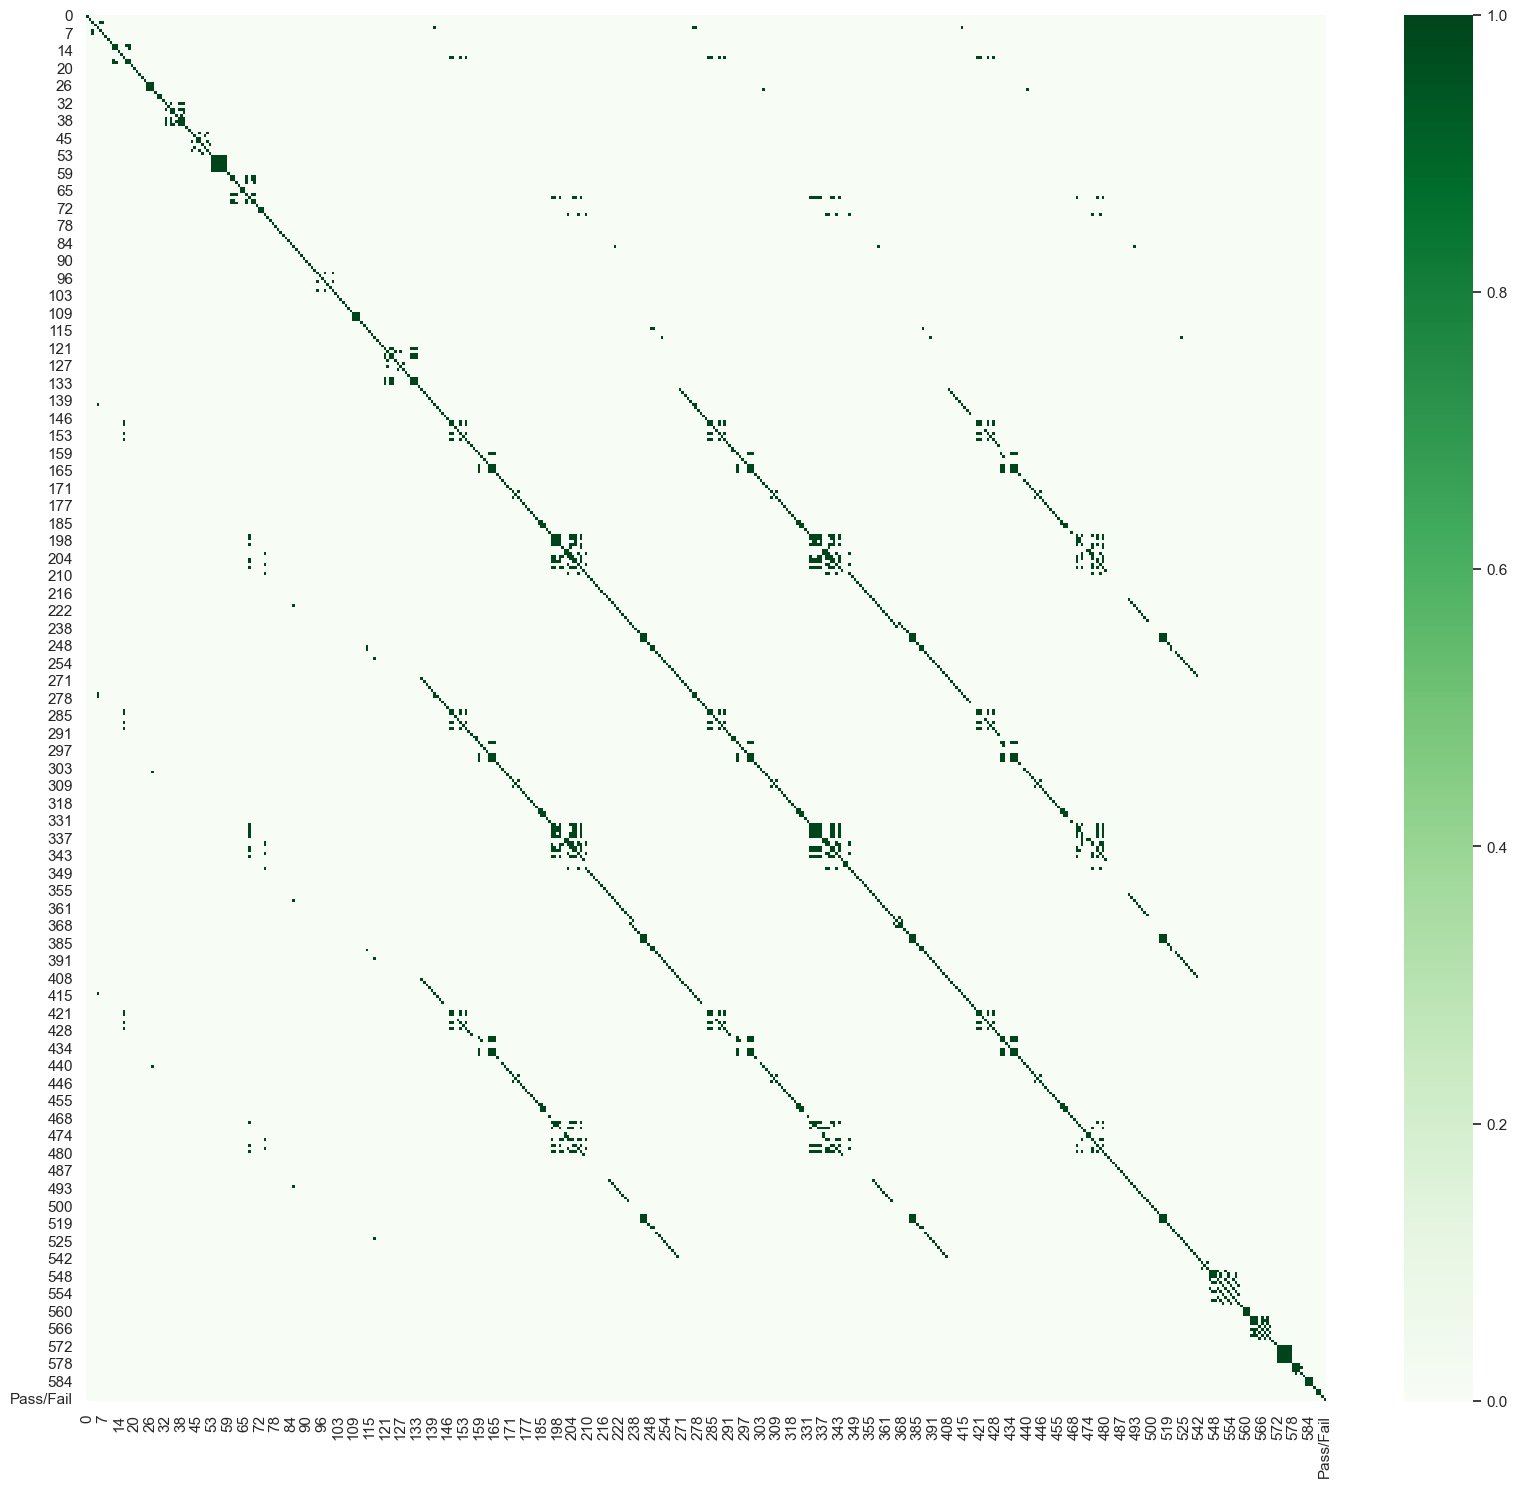

In [32]:
#checking for correlation 
plt.figure(figsize=(20,18))
corr=com.corr()
sns.heatmap(abs(corr>0.7),cmap="Greens");

In [33]:
#making a copy of the dataset and dropping the target class
com1=com.copy()
com1.drop(['Pass/Fail'],axis=1,inplace=True)

In [37]:
# # Create correlation matrix
# corr_matrix = com1.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.70
# to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# # Drop features 
# com1.drop(to_drop, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = com1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features
com1.drop(to_drop, axis=1, inplace=True)

In [38]:
row,column=com1.shape
print('After dropping the correlated variables the dataset contains', row, 'rows and', column, 'columns')

After dropping the correlated variables the dataset contains 1567 rows and 195 columns


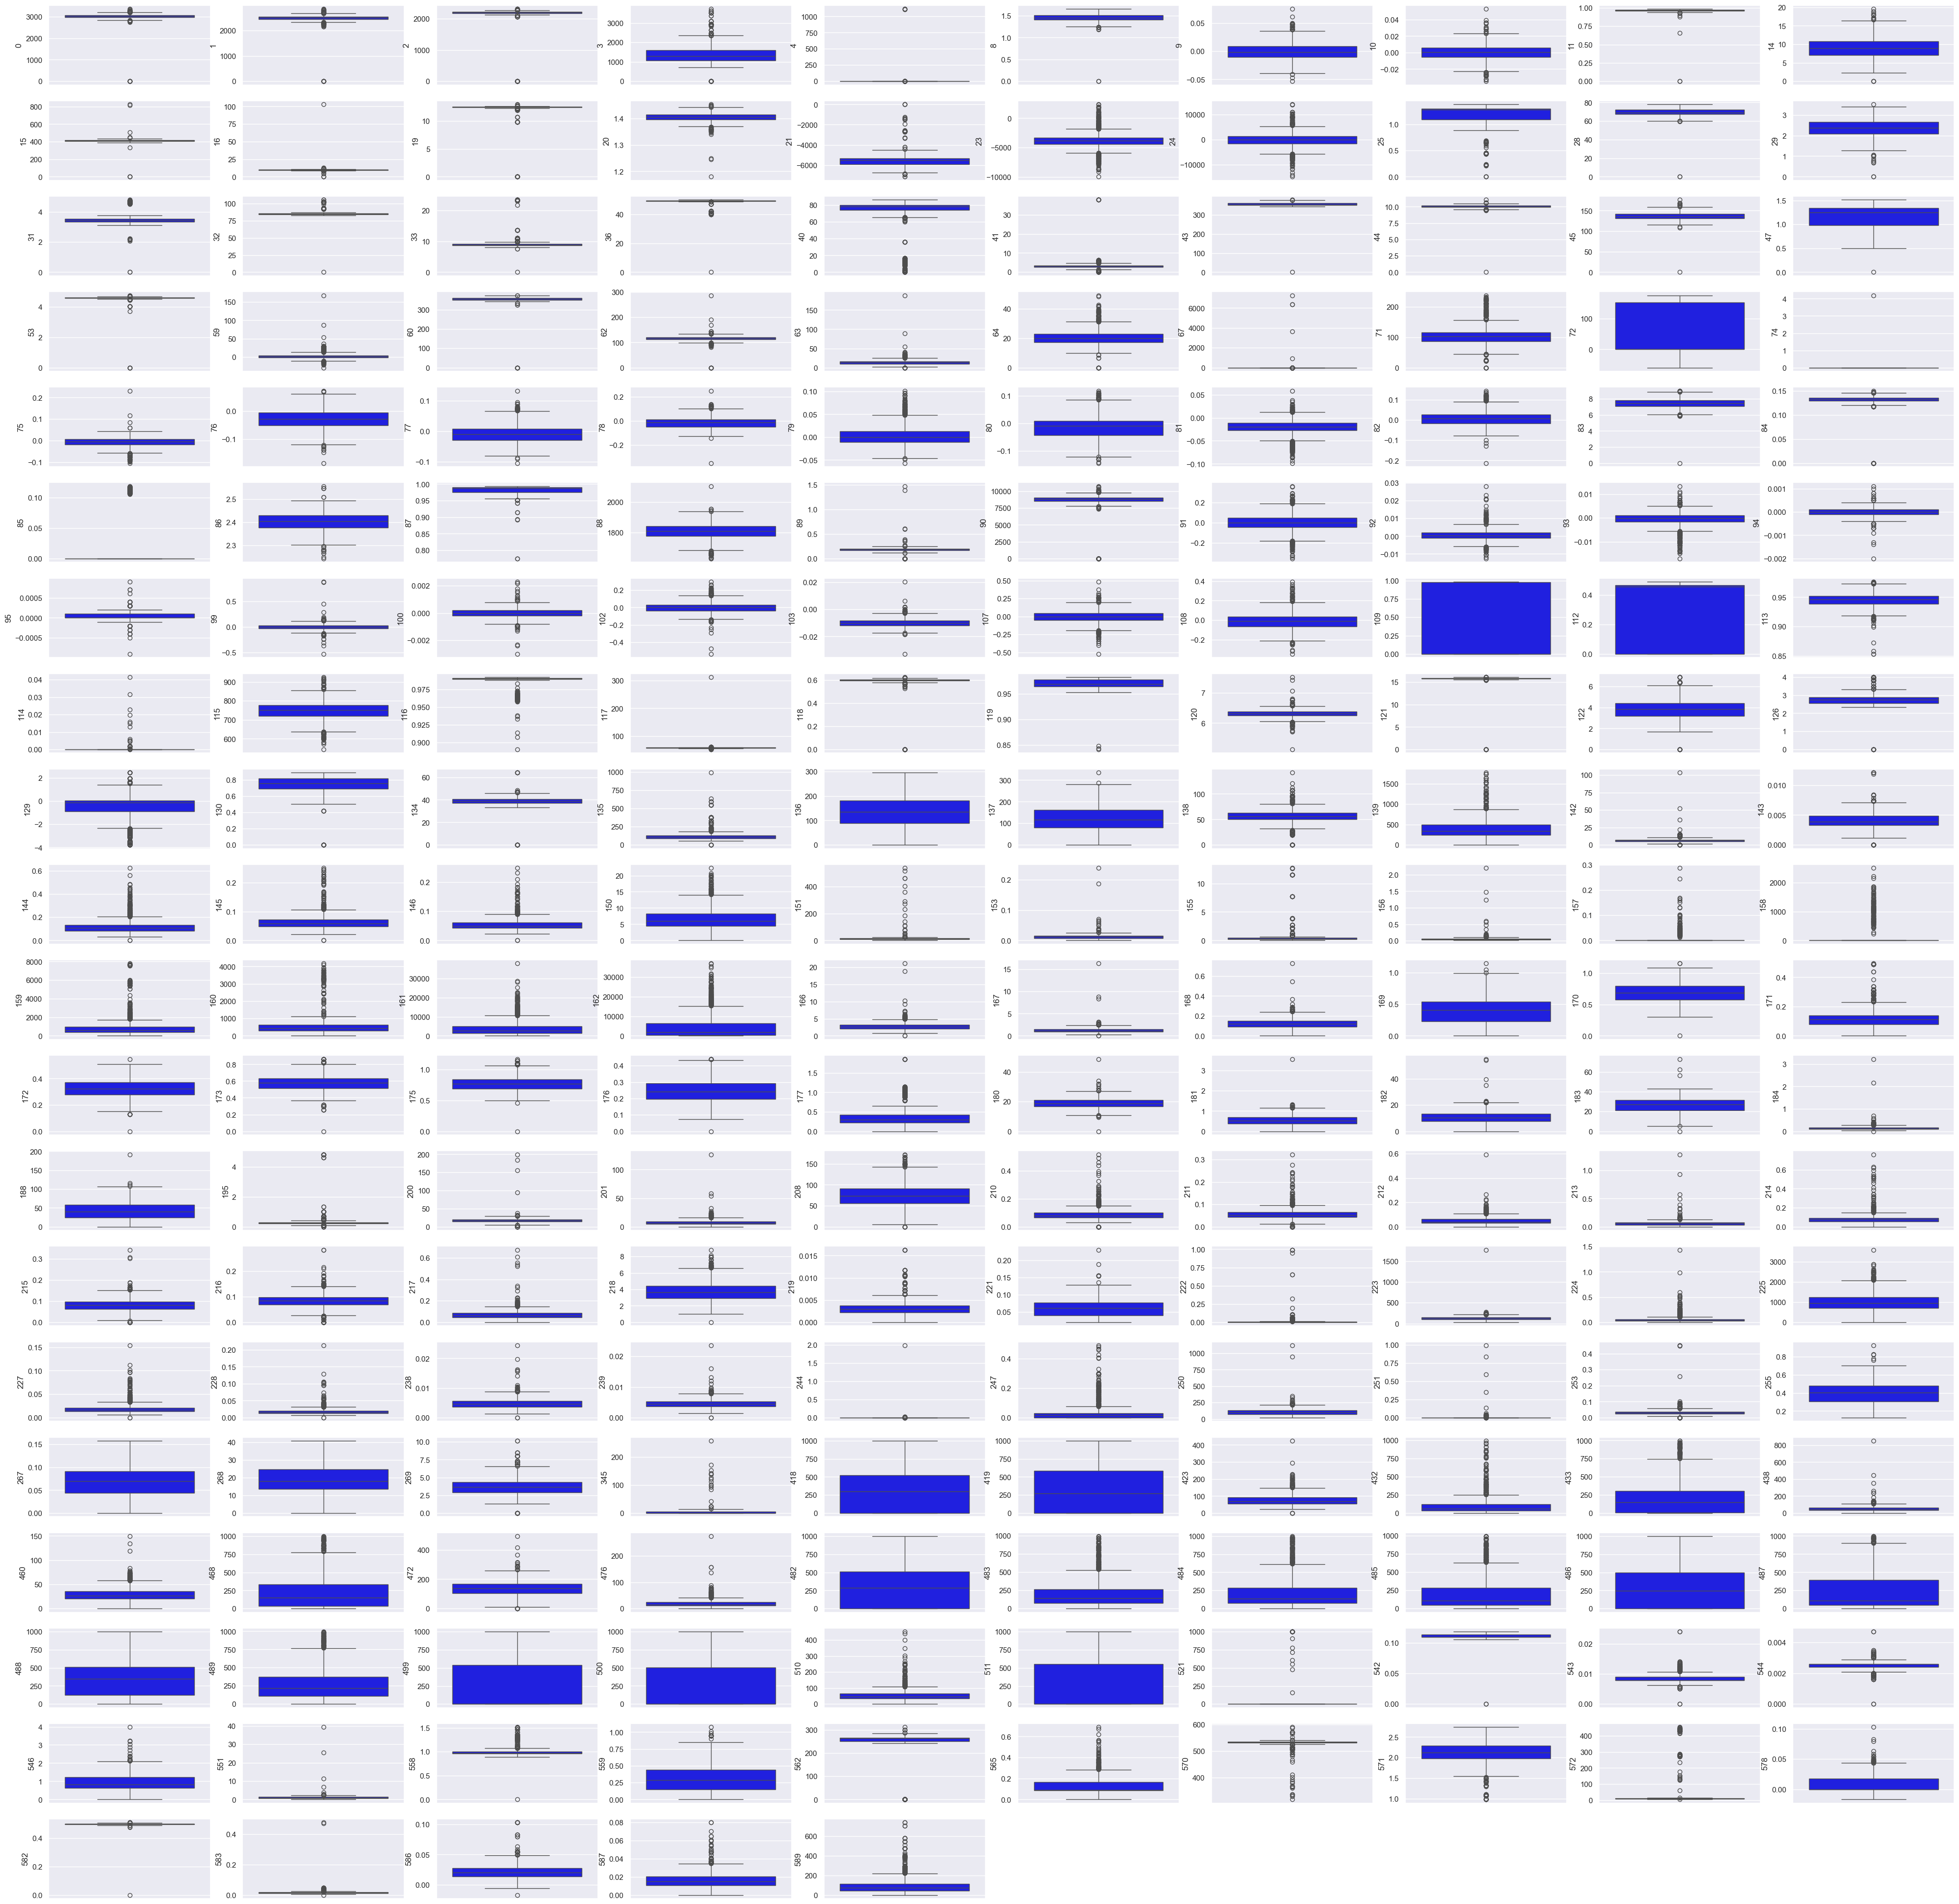

In [39]:
#Boxplot to check for outliers
plt.figure(figsize=(50, 50))
col = 1
for i in com1.columns:
    plt.subplot(20,10, col)
    sns.boxplot(com1[i],color='blue')
    col += 1

Majority of the attributes have outliers, will be replacing them with the median

In [40]:
#find the outliers and replace them by median
for i in com1.columns:
    q1 = com1[i].quantile(0.25)
    q3 = com1[i].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    com1.loc[(com1[i] < low) | (com1[i] > high), i] = com1[i].median()

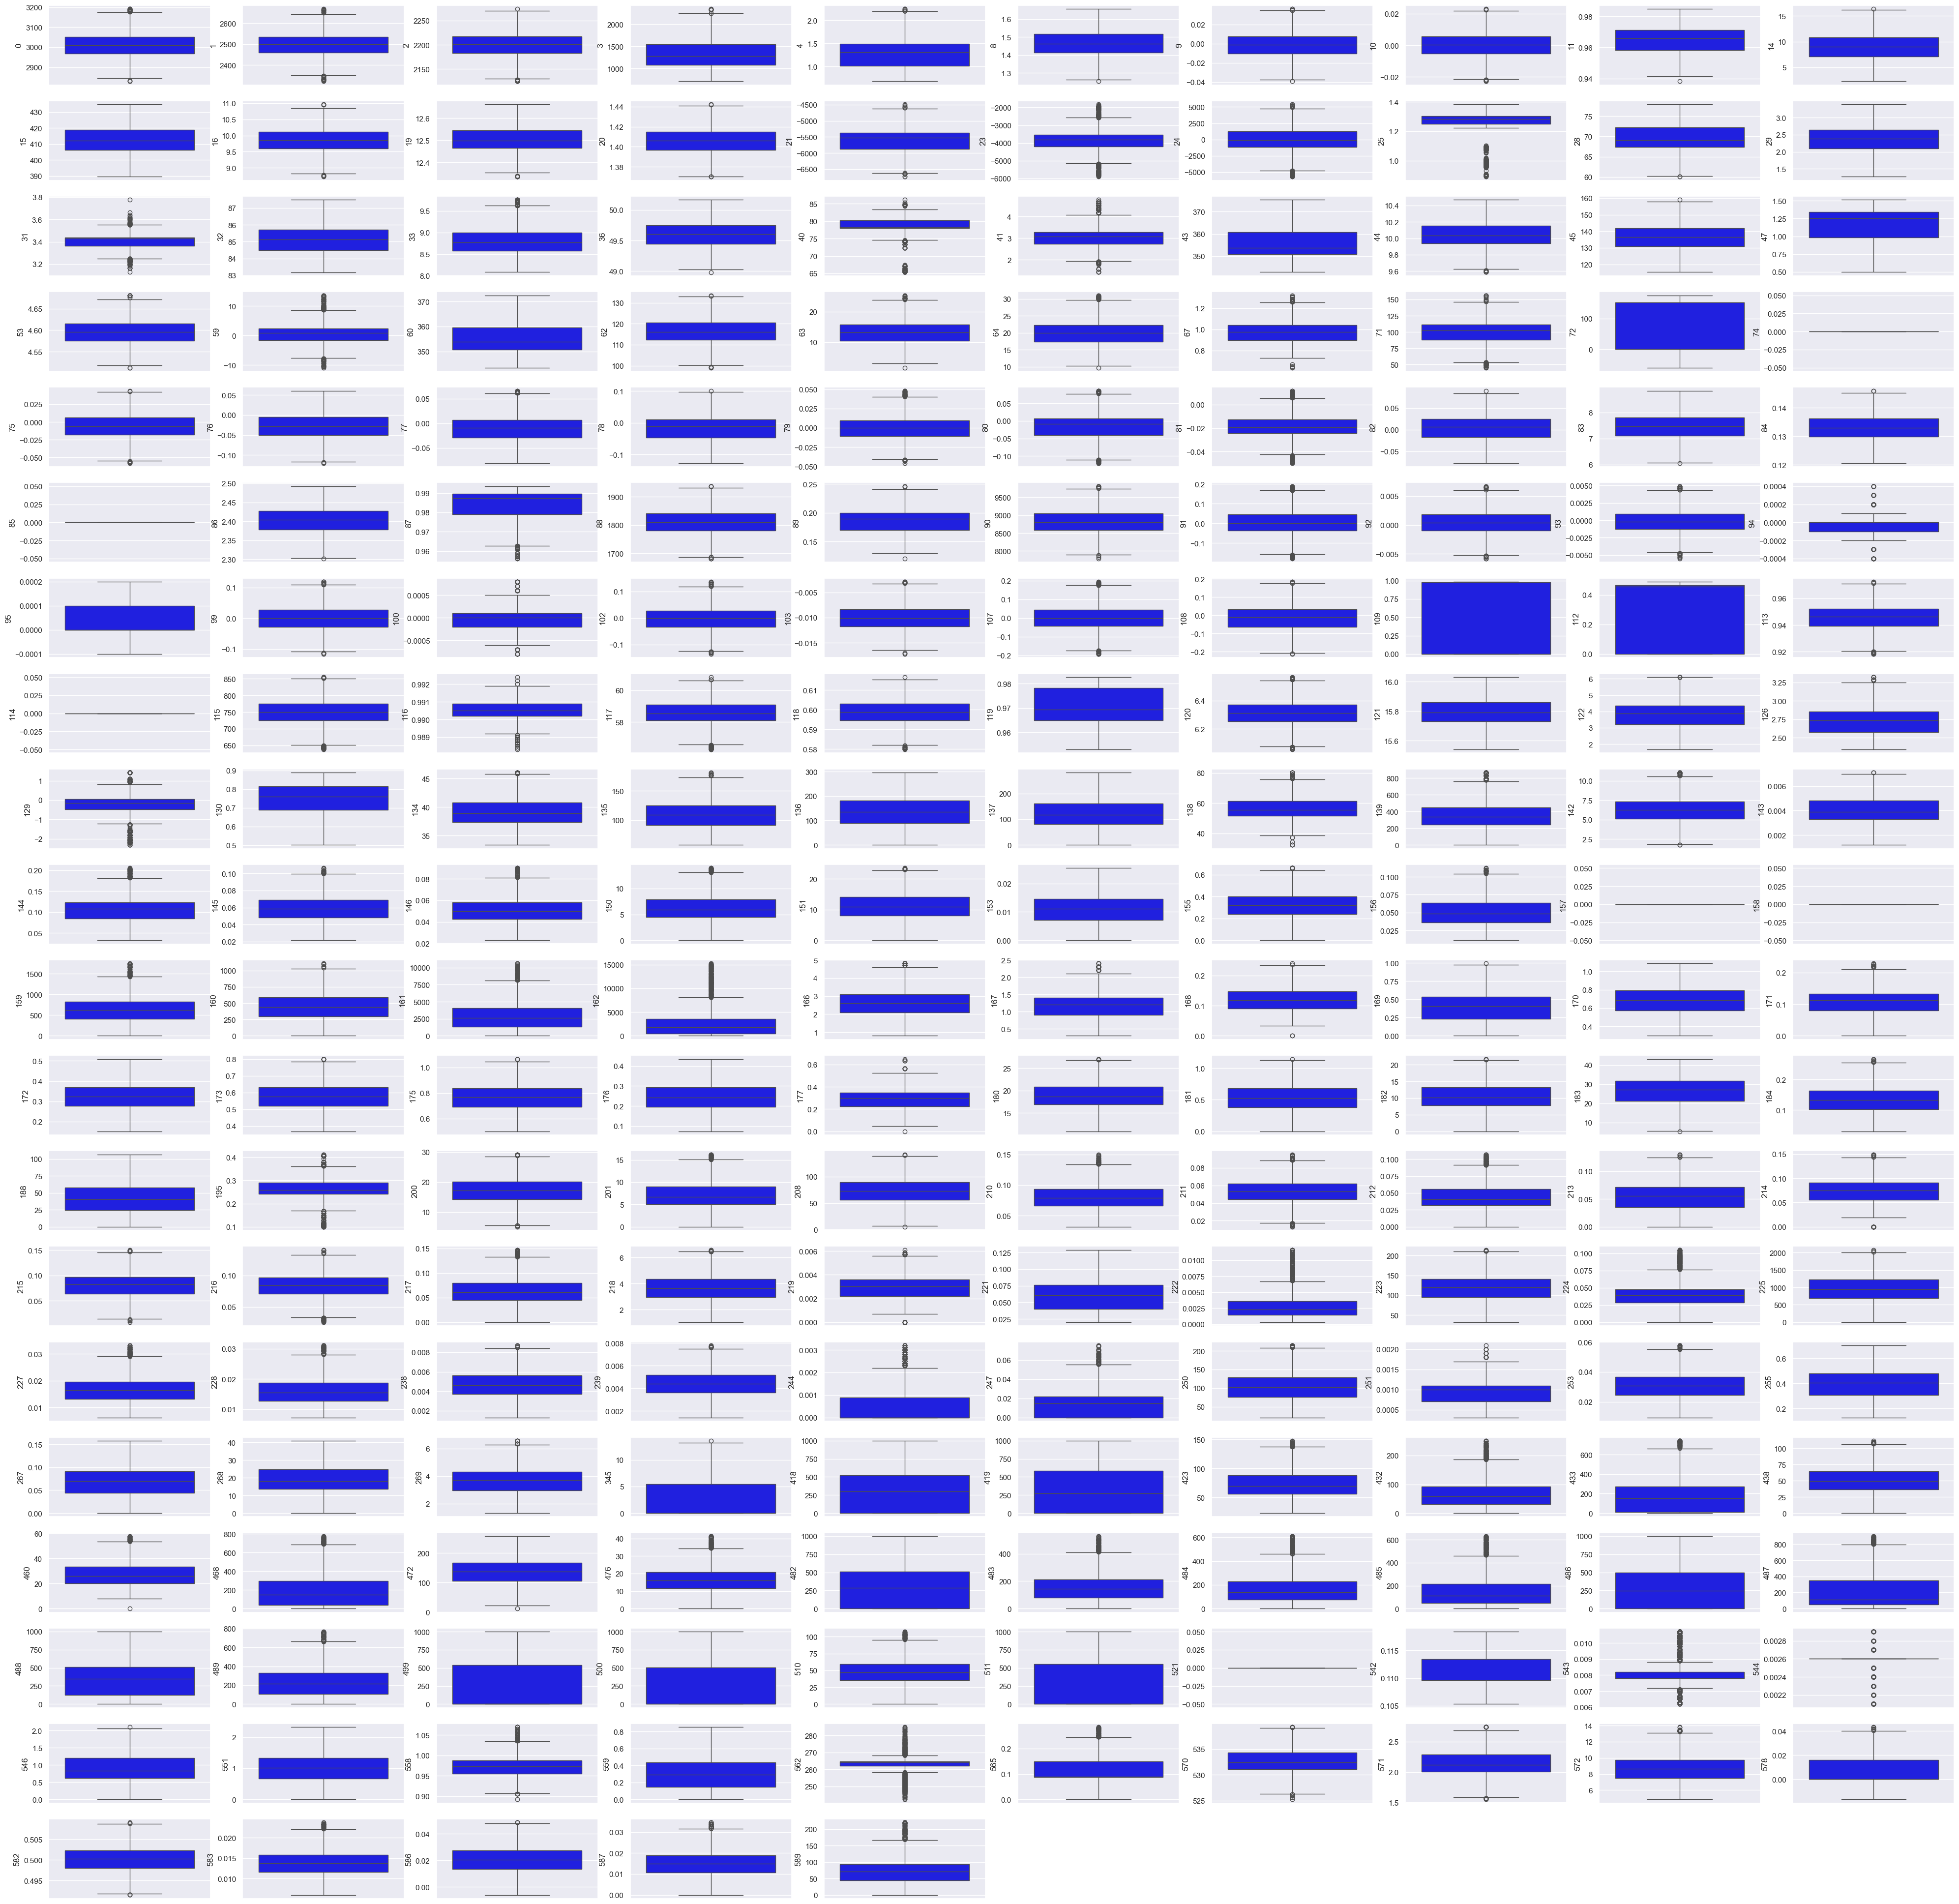

In [41]:
#After treating the outlier values
plt.figure(figsize=(50, 50))
col = 1
for i in com1.columns:
    plt.subplot(20,10, col)
    sns.boxplot(com1[i],color='blue')
    col += 1

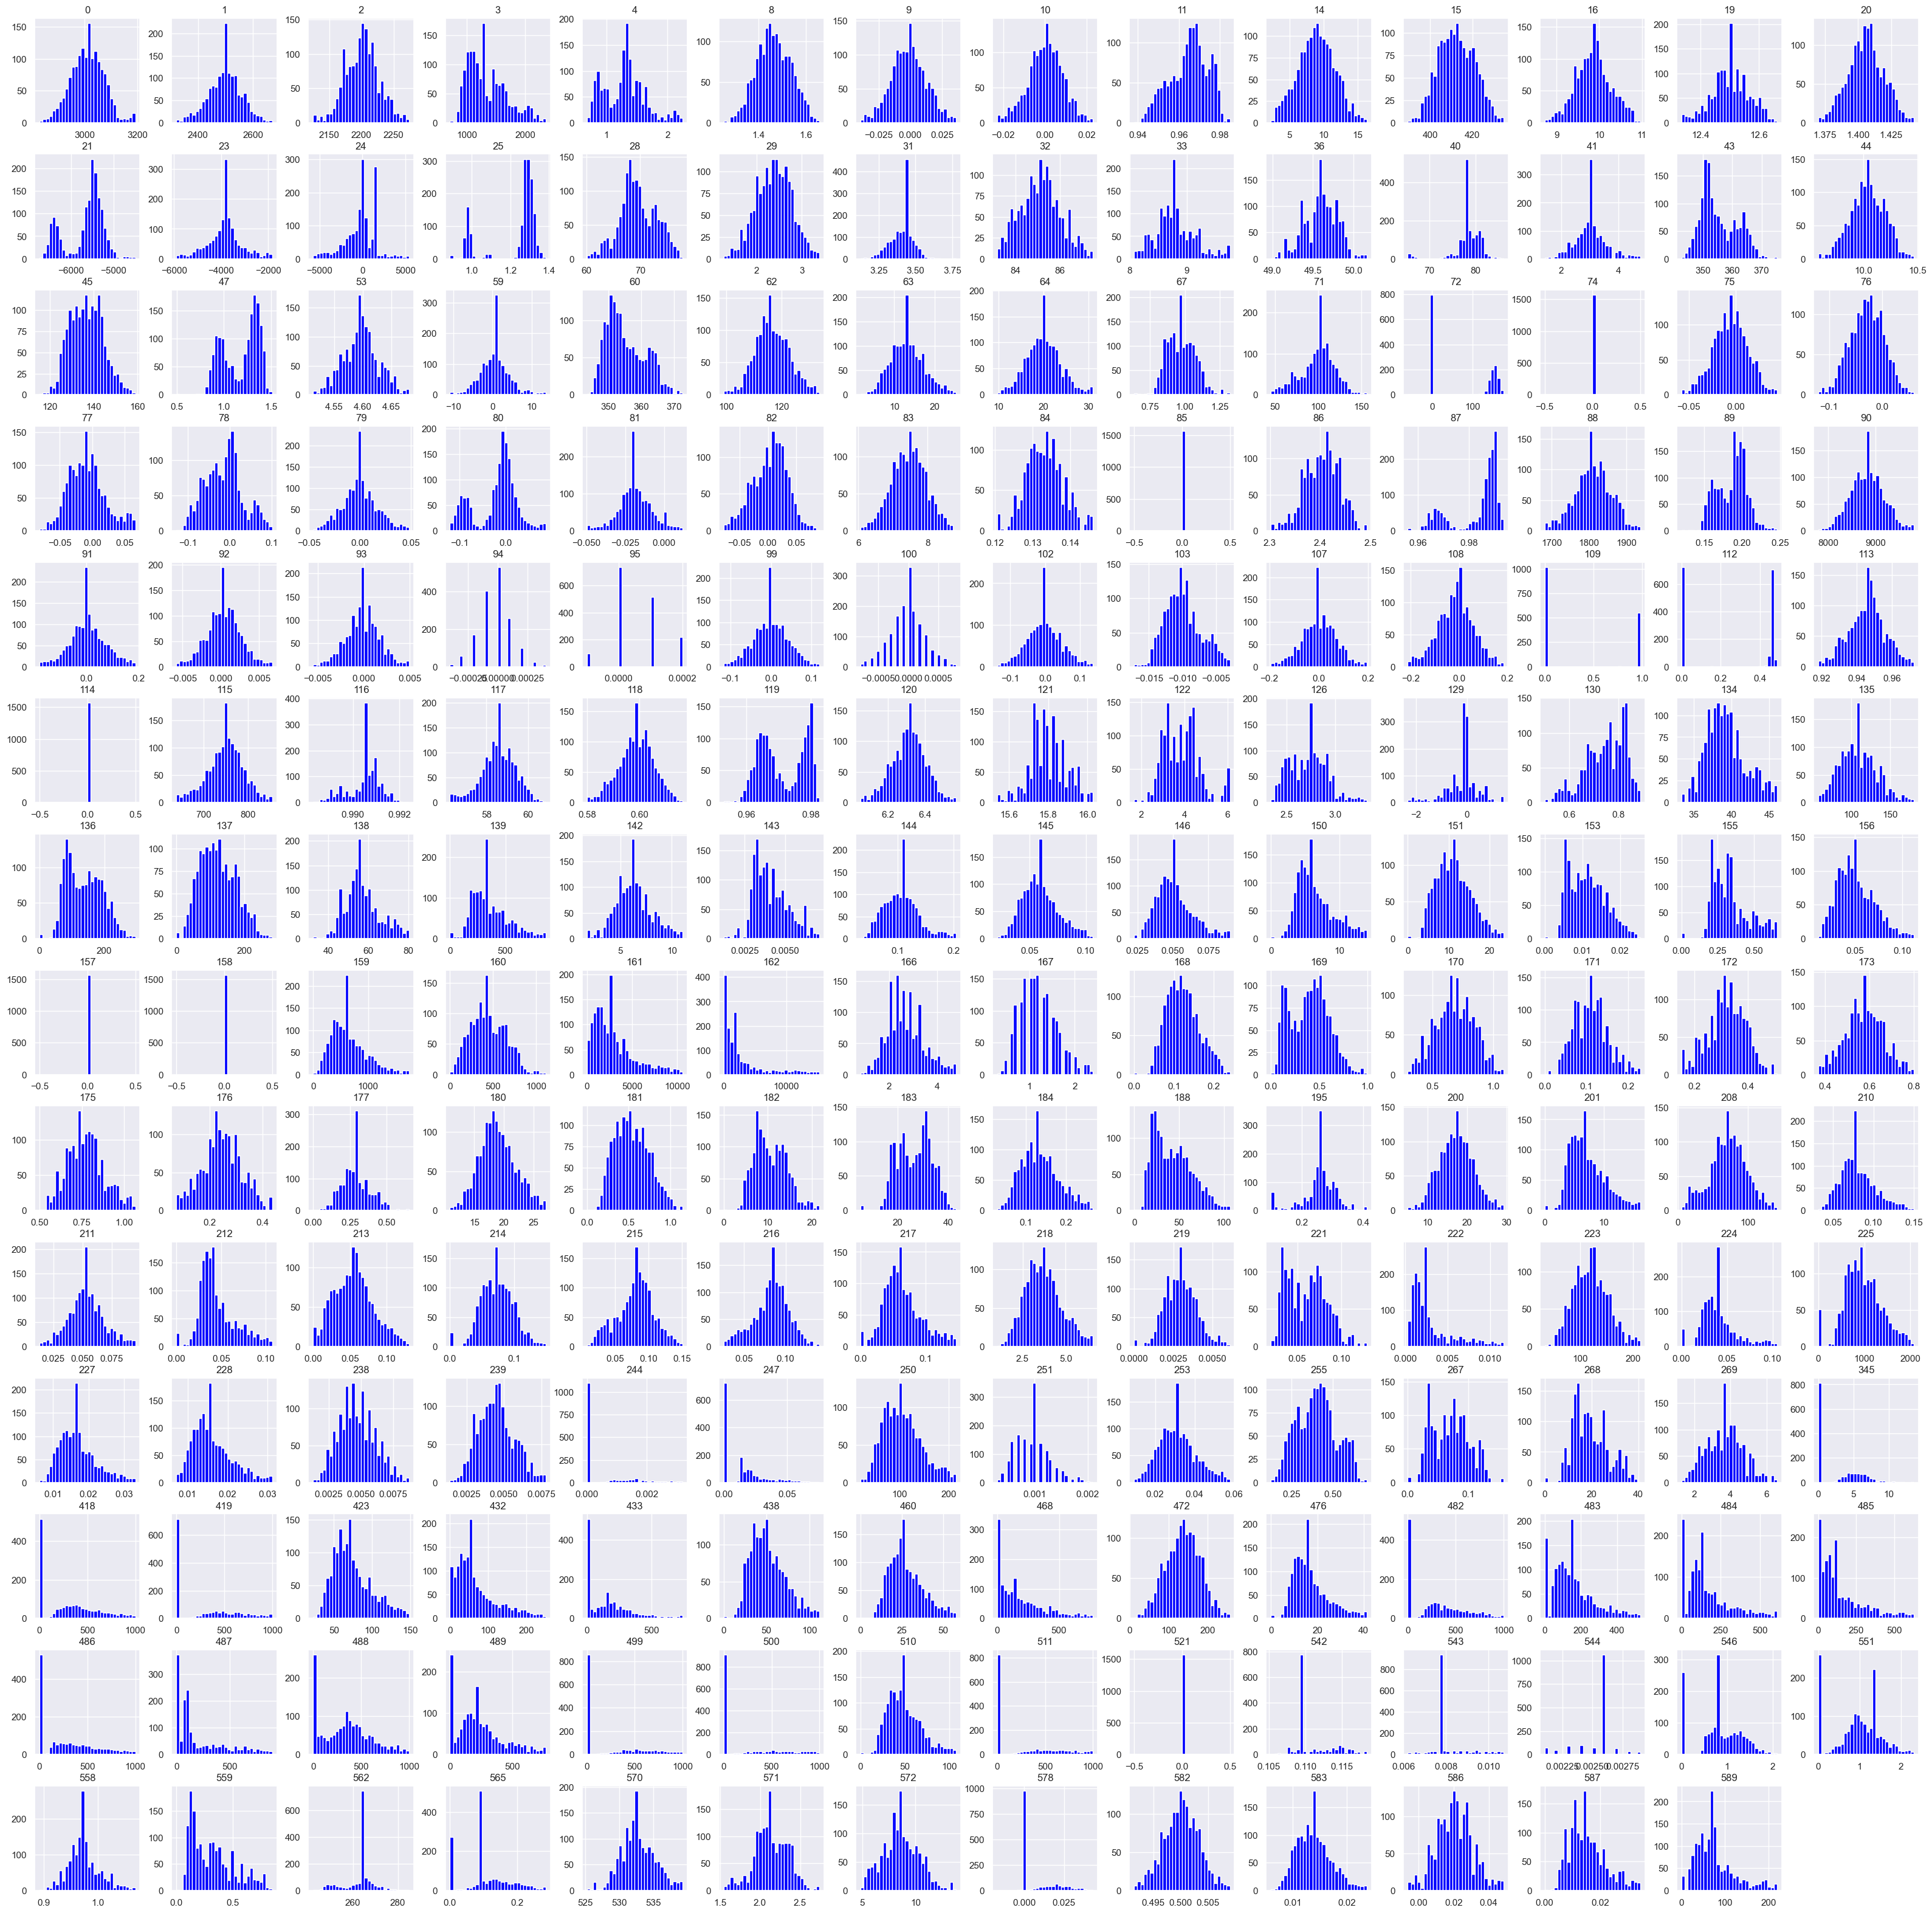

In [42]:
#plotting histogram to check for the frequency of values within a variable
com1.hist(bins = 30, figsize = (40, 40), color = 'blue')
plt.show()

Some variables have still have 0 as a constant signal, will be drooping them after scaling with z-score

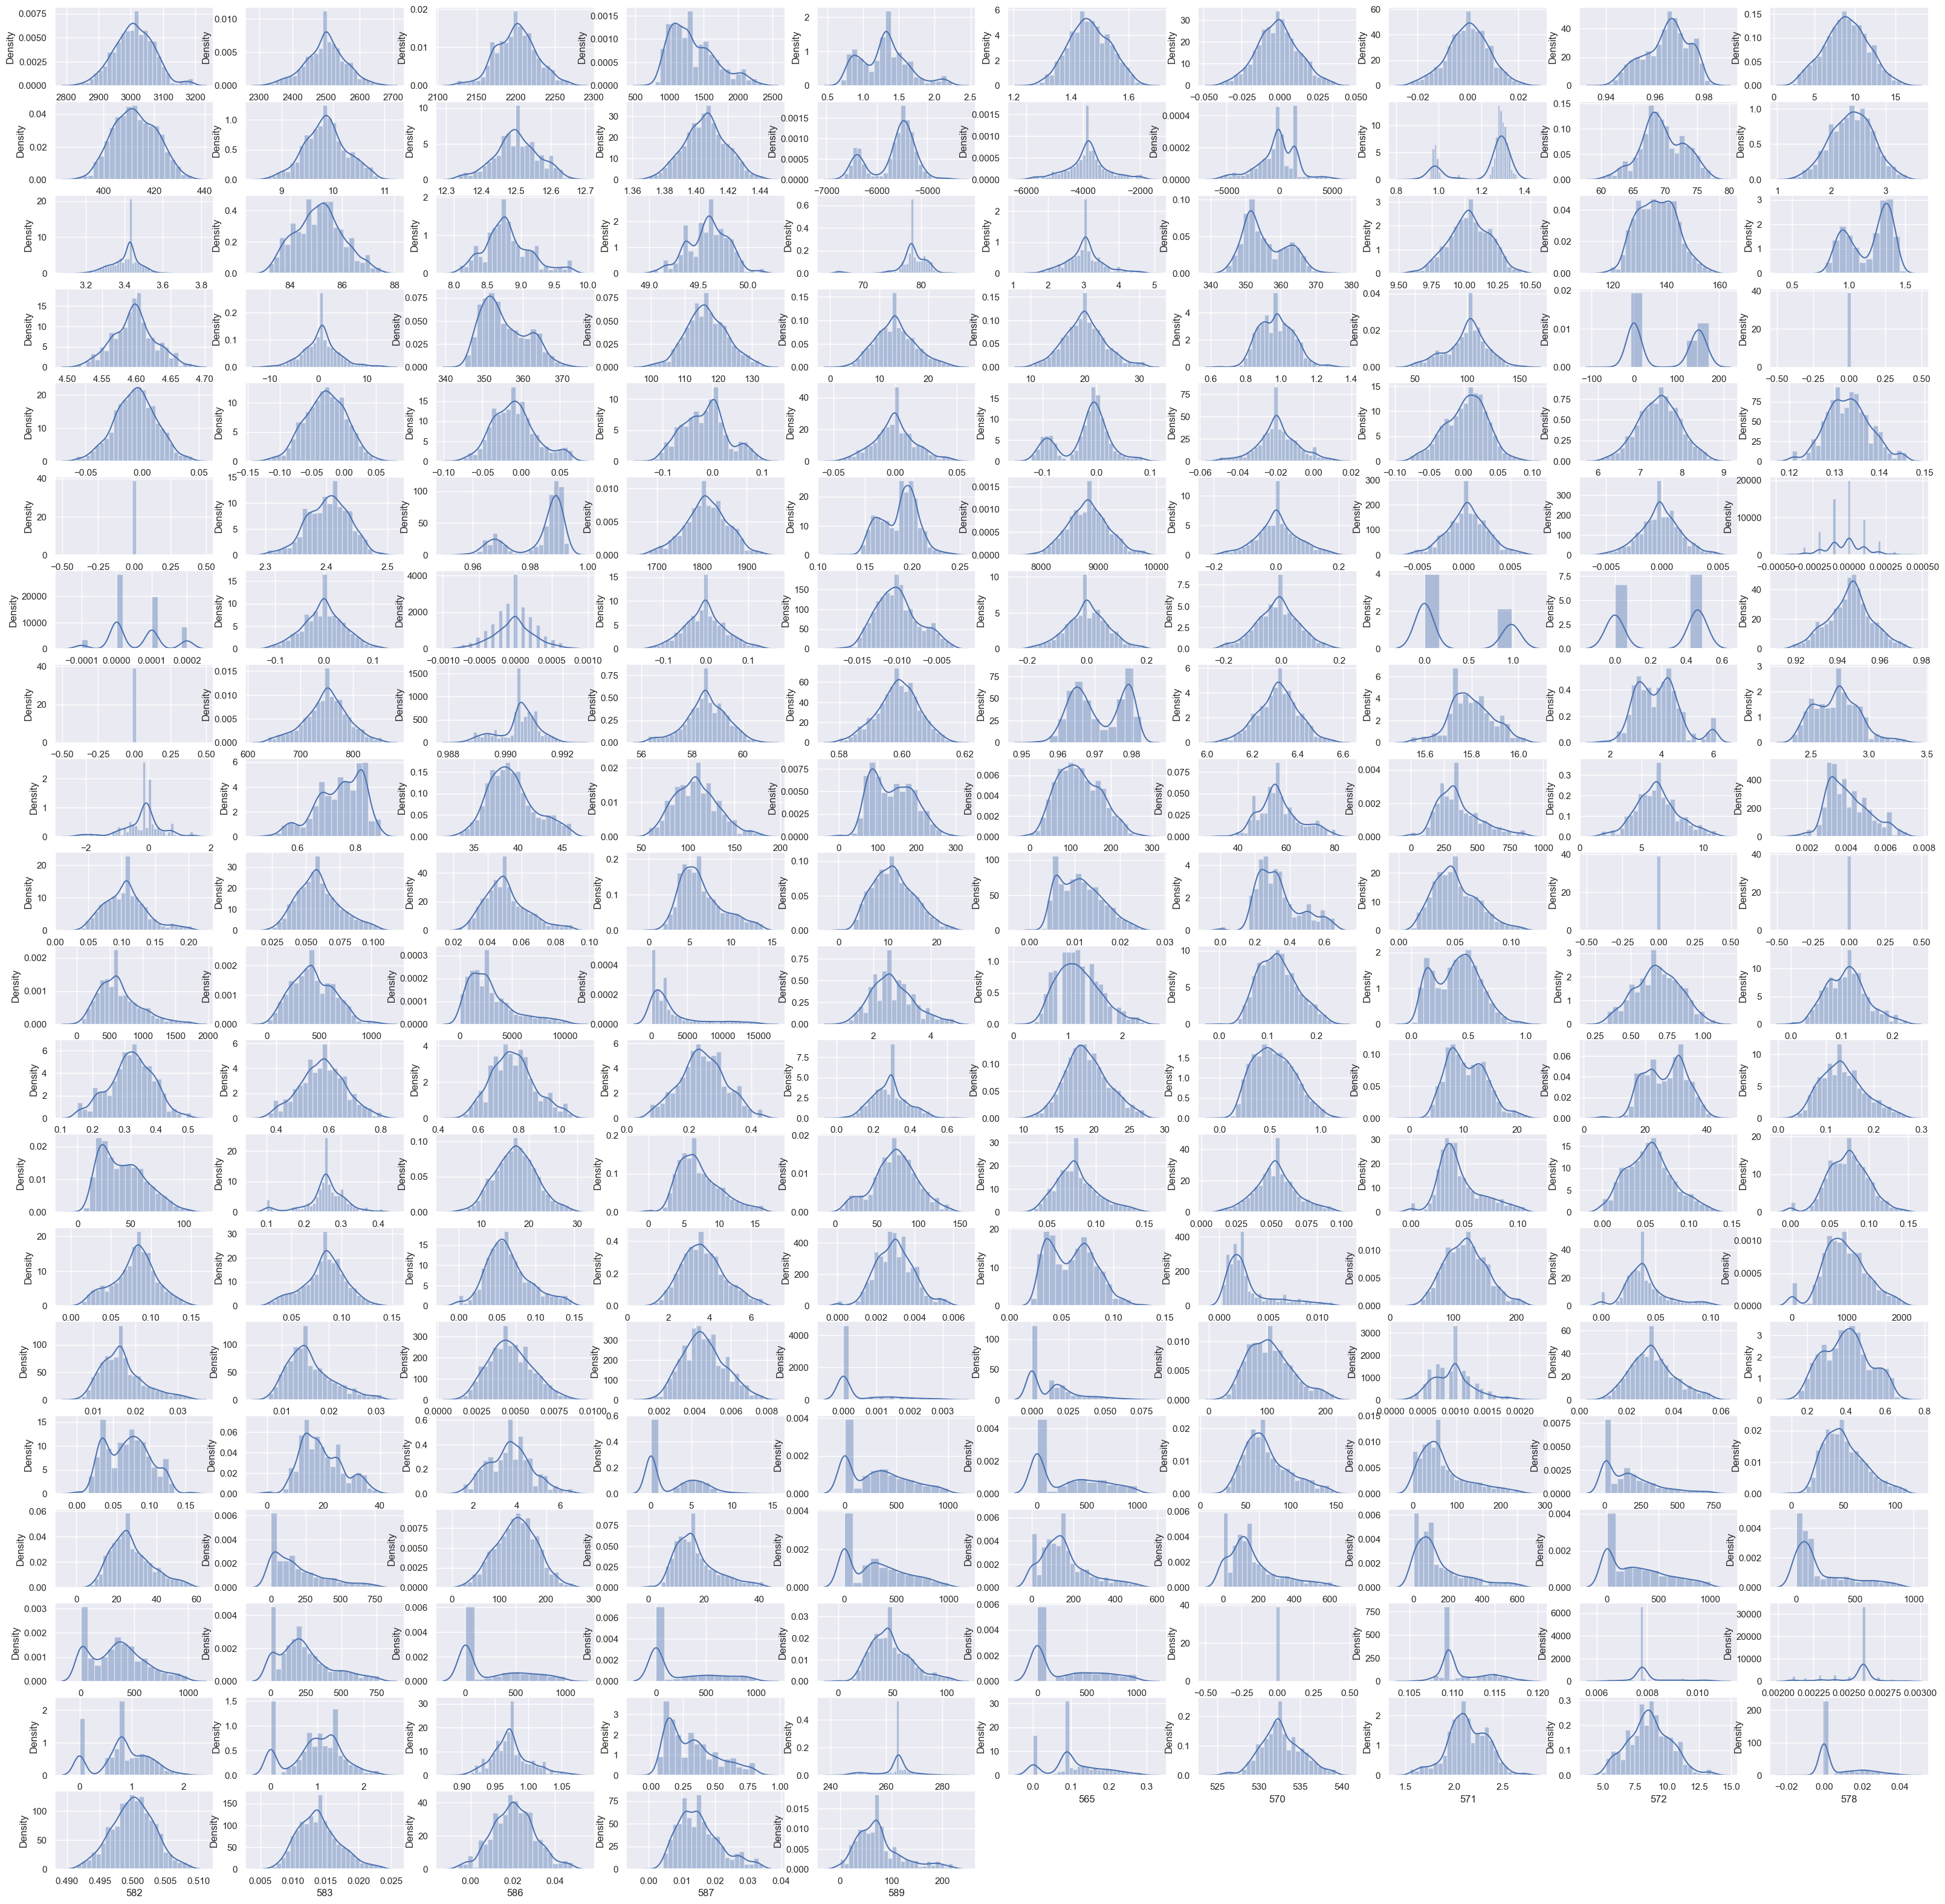

In [43]:
#density plot to check for the distribution of the variables
plt.figure(figsize=(40, 40))
col = 1
for i in com1.columns:
    plt.subplot(20, 10, col)
    sns.distplot(com1[i], color = 'b')
    col += 1 

Majority of the variable seem to have a normal distribution

In [44]:
#scaling with z-score
comScaled= com1.apply(zscore)  
comScaled.describe().T

count          mean       std       min       25%       50%       75%  \
0    1567.0 -1.902187e-15  1.000319 -2.899903 -0.672689  0.019204  0.678857   
1    1567.0 -2.446883e-15  1.000319 -2.921819 -0.621101  0.033772  0.627439   
2    1567.0  5.559192e-15  1.000319 -2.911031 -0.699474  0.005639  0.646028   
3    1567.0  4.443726e-16  1.000319 -1.895521 -0.778479 -0.182909  0.619699   
4    1567.0  2.902025e-16  1.000319 -1.845115 -0.836008  0.041632  0.583103   
..      ...           ...       ...       ...       ...       ...       ...   
582  1567.0 -3.752228e-15  1.000319 -2.652869 -0.646439  0.032661  0.680892   
583  1567.0  4.307694e-17  1.000319 -2.479996 -0.719792 -0.028283  0.600361   
586  1567.0 -1.269636e-16  1.000319 -2.604473 -0.697261 -0.005957  0.670637   
587  1567.0  2.085831e-16  1.000319 -2.338066 -0.724073 -0.084566  0.554941   
589  1567.0  4.534414e-18  1.000319 -1.683169 -0.706037 -0.102398  0.382611   

          max  
0    2.921707  
1    2.868115  
2    2.795421  
3    3.001915  
4    2.847439  
..        ...  
582  2.749059  
583  3.083507  
586  2.729839  
587  2.915025  
589  3.162735  

[195 rows x 8 columns]

In [45]:
#combining the data
y=com['Pass/Fail']
comb=pd.concat([comScaled,y],axis=1)

In [46]:
#dropping NaN
comb.dropna(axis=1,inplace=True)
row,column=comb.shape
print('After dropping NaN variables the dataset contains', row, 'rows and', column, 'columns')

After dropping NaN variables the dataset contains 1567 rows and 190 columns


In [48]:
com.columns

Index(['0', '1', '2', '3', '4', '6', '7', '8', '9', '10',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=475)

In [55]:
comb.shape

(1567, 190)

In [56]:
#splitting the dataset into train and validation set
X=comb.iloc[0:1567,:]
val=comb.iloc[1567:,:190]

In [57]:
val.columns

Index(['0', '1', '2', '3', '4', '8', '9', '10', '11', '14',
       ...
       '570', '571', '572', '578', '582', '583', '586', '587', '589',
       'Pass/Fail'],
      dtype='object', length=190)

In [58]:
val=val.drop(['Pass/Fail'],axis=1)

In [59]:
#creating a copy of the train data and seperating the target column and the predictor variables
sg=X.copy()
X=sg.drop(['Pass/Fail'],axis=1)
y=sg['Pass/Fail']

In [60]:
row,column=val.shape
print('The reduced validation dataset contains', row, 'rows and', column, 'columns')

The reduced validation dataset contains 0 rows and 189 columns


In [61]:
row,column=X.shape
print('The reduced training dataset contains', row, 'rows and', column, 'columns')

The reduced training dataset contains 1567 rows and 189 columns


## Trying various algorithms along with different sampling techniques

### Splitting the Past data into train and test 70:30 ratio

In [62]:
# splitting data training dataset into train and test set for independent attributes
X_train, X_test, Y_train, Y_test =train_test_split(X,y, test_size=.30,random_state=105,stratify=y)

In [63]:
print("Training Fail    : {0} ({1:0.2f}%)".format(len(Y_train[Y_train[:] == 1]), (len(Y_train[Y_train[:] == 1])/len(Y_train)) * 100))
print("Training Pass  : {0} ({1:0.2f}%)".format(len(Y_train[Y_train[:] == 0]), (len(Y_train[Y_train[:] == 0])/len(Y_train)) * 100))
print("")
print("Test Fail        : {0} ({1:0.2f}%)".format(len(Y_test[Y_test[:] == 1]), (len(Y_test[Y_test[:] == 1])/len(Y_test)) * 100))
print("Test Pass       : {0} ({1:0.2f}%)".format(len(Y_test[Y_test[:] == 0]), (len(Y_test[Y_test[:] == 0])/len(Y_test)) * 100))
print("")

Training Fail    : 73 (6.66%)
Training Pass  : 1023 (93.34%)

Test Fail        : 31 (6.58%)
Test Pass       : 440 (93.42%)



-----------

### No sampling

In [64]:
# Initializaing various classification algorithms with normal dataset and choosing the best model based on f1 score for tuning

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 11.928382% (11.162735%)
KNN: 2.500000% (7.500000%)
GNB: 17.263359% (5.554500%)
SVM: 16.345238% (9.904566%)
DT: 13.451573% (10.452025%)
RF: 0.000000% (0.000000%)
AB: 5.427350% (8.448254%)
GBT: 6.262626% (9.623035%)
XGB: 0.000000% (0.000000%)
[LightGBM] [Info] Number of positive: 66, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39961
[LightGBM] [Info] Number of data points in the train set: 986, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066937 -> initscore=-2.634719
[LightGBM] [Info] Start training from score -2.634719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 66, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_co

--------------

###  Random undersampling

In [66]:
# Implementing random under sampling
under= RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under= under.fit_resample(X_train, Y_train)

In [67]:
print("Under Training Fail    : {0} ({1:0.2f}%)".format(len(y_under[y_under[:] == 1]), (len(y_under[y_under[:] == 1])/len(y_under)) * 100))
print("under Training Pass  : {0} ({1:0.2f}%)".format(len(y_under[y_under[:] == 0]), (len(y_under[y_under[:] == 0])/len(y_under)) * 100))


Under Training Fail    : 73 (33.33%)
under Training Pass  : 146 (66.67%)


In [68]:
# Initializaing various classification algorithms with random under sampler dataset and choosing the best model based on f1 score

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=66,shuffle=True)
    cv_results = cross_val_score(model, X_under, y_under, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 49.839376% (15.826376%)
KNN: 53.433455% (17.271963%)
GNB: 52.557207% (16.491238%)
SVM: 47.503418% (15.737090%)
DT: 36.466063% (18.116048%)
RF: 24.232323% (13.601711%)
AB: 38.256518% (12.246272%)
GBT: 25.151515% (19.580781%)
XGB: 35.522922% (14.245976%)
[LightGBM] [Info] Number of positive: 66, number of negative: 131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10360
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335025 -> initscore=-0.685543
[LightGBM] [Info] Start training from score -0.685543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

---------------

###  Smote

In [70]:
# Implementing SMOTE
smt = SMOTE(sampling_strategy=0.5)
X_SMOTE, y_SMOTE = smt.fit_resample(X_train, Y_train)

In [71]:
print("SMOTE Training Fail    : {0} ({1:0.2f}%)".format(len(y_SMOTE[y_SMOTE[:] == 1]), (len(y_SMOTE[y_SMOTE[:] == 1])/len(y_SMOTE)) * 100))
print("SMOTE Training Pass  : {0} ({1:0.2f}%)".format(len(y_SMOTE[y_SMOTE[:] == 0]), (len(y_SMOTE[y_SMOTE[:] == 0])/len(y_SMOTE)) * 100))


SMOTE Training Fail    : 511 (33.31%)
SMOTE Training Pass  : 1023 (66.69%)


In [72]:
# Initializaing various classification algorithms with Smote dataset and choosing the best model based on f1 score

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=25,shuffle=True)
    cv_results = cross_val_score(model, X_SMOTE, y_SMOTE, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 87.804671% (2.723032%)
KNN: 53.352086% (0.761050%)
GNB: 81.281953% (3.394765%)
SVM: 88.510317% (2.737664%)
DT: 81.543689% (5.313570%)
RF: 96.544875% (1.659263%)
AB: 87.386883% (2.709457%)
GBT: 95.193589% (1.476671%)
XGB: 97.013823% (1.346121%)
[LightGBM] [Info] Number of positive: 460, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46667
[LightGBM] [Info] Number of data points in the train set: 1380, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 460, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466

-------------

### Random Oversampling

In [73]:
# Implementing random over sampling
over= RandomOverSampler(sampling_strategy=0.5)
X_over, y_over= over.fit_resample(X_train, Y_train)

In [74]:
print("over Training Fail    : {0} ({1:0.2f}%)".format(len(y_over[y_over[:] == 1]), (len(y_over[y_over[:] == 1])/len(y_over)) * 100))
print("over Training Pass  : {0} ({1:0.2f}%)".format(len(y_over[y_over[:] == 0]), (len(y_over[y_over[:] == 0])/len(y_over)) * 100))


over Training Fail    : 511 (33.31%)
over Training Pass  : 1023 (66.69%)


In [75]:
# Initializaing various classification algorithms with over sampled dataset and choosing the best model based on f1 score

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=69,shuffle=True)
    cv_results = cross_val_score(model, X_over, y_over, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 88.170098% (2.254132%)
KNN: 87.158833% (2.352943%)
GNB: 66.536539% (5.405178%)
SVM: 89.060185% (2.354750%)
DT: 94.093208% (2.478475%)
RF: 100.000000% (0.000000%)
AB: 91.619992% (2.221715%)
GBT: 99.228902% (0.838686%)
XGB: 99.331379% (1.122372%)
[LightGBM] [Info] Number of positive: 460, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40354
[LightGBM] [Info] Number of data points in the train set: 1380, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 460, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40

------

### ADASYN sampling

In [76]:
oversample = ADASYN(sampling_strategy=0.5)
X_adasyn, y_adasyn = oversample.fit_resample(X_train, Y_train)

In [77]:
print("ADASYN Training Fail    : {0} ({1:0.2f}%)".format(len(y_adasyn[y_adasyn[:] == 1]), (len(y_adasyn[y_adasyn[:] == 1])/len(y_adasyn)) * 100))
print("ADASYN Training Pass  : {0} ({1:0.2f}%)".format(len(y_adasyn[y_adasyn[:] == 0]), (len(y_adasyn[y_adasyn[:] == 0])/len(y_adasyn)) * 100))


ADASYN Training Fail    : 504 (33.01%)
ADASYN Training Pass  : 1023 (66.99%)


In [78]:
# Initializaing various classification algorithms with ADASYN dataset and choosing the best model based on f1 score

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=33,shuffle=True)
    cv_results = cross_val_score(model, X_adasyn, y_adasyn, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 87.414902% (2.601413%)
KNN: 53.564820% (0.655663%)
GNB: 80.171698% (3.535641%)
SVM: 88.847695% (2.524899%)
DT: 82.116321% (4.836695%)
RF: 97.026257% (1.209292%)
AB: 87.529576% (2.981762%)
GBT: 95.863348% (1.202864%)
XGB: 97.694230% (1.286929%)
[LightGBM] [Info] Number of positive: 454, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46648
[LightGBM] [Info] Number of data points in the train set: 1374, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330422 -> initscore=-0.706276
[LightGBM] [Info] Start training from score -0.706276
[LightGBM] [Info] Number of positive: 454, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466

------

### Gaussian Naive Bayes on Normal Dataset

In [79]:
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

In [80]:
modelnb_score = nb.score(X_train, Y_train)
print('Accuracy Score of Training Data: ', modelnb_score)

Accuracy Score of Training Data:  0.8640510948905109


In [81]:
y_predictnb= nb.predict(X_test)
modelnb_score = accuracy_score(Y_test, y_predictnb)
print('Accuracy Score of Test Data:', modelnb_score)

Accuracy Score of Test Data: 0.8492569002123143


In [82]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictnb, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.21      0.45      0.28        31
           0       0.96      0.88      0.92       440

    accuracy                           0.85       471
   macro avg       0.58      0.66      0.60       471
weighted avg       0.91      0.85      0.87       471



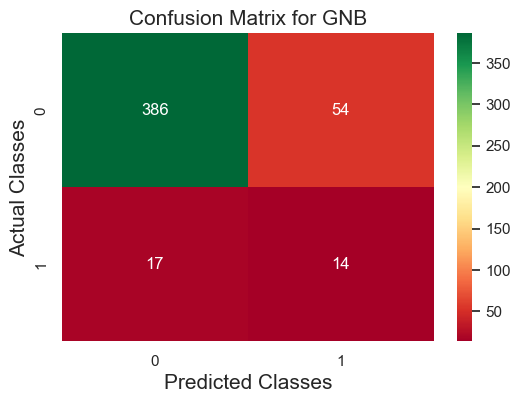

In [83]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictnb)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Predicted Classes', fontsize = 15)
plt.ylabel('Actual Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB', fontsize = 15);

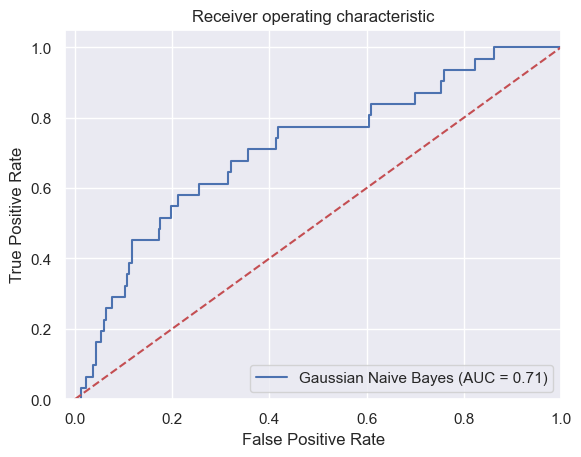

In [84]:
#Plotting ROC and AUC
probs = nb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_nb = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='Gaussian Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [85]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
39  0.320455  0.677419  0.679545 -0.002126   0.014717


In [87]:
# # store the predicted probabilities for Failed Class. 
# y_pred_prob = nb.predict_proba(X_test)[:, 1]
# # predict diabetes if the predicted probability is greater than 0.0161
# y_pred_class = binarize([y_pred_prob], 0.0161)[0]

from sklearn.preprocessing import binarize

# Store the predicted probabilities for the failed class
y_pred_prob = nb.predict_proba(X_test)[:, 1]

# Reshape y_pred_prob to 2D array and predict diabetes if the predicted probability is greater than 0.0161
y_pred_class = binarize(y_pred_prob.reshape(-1, 1), threshold=0.0161)[:, 0]


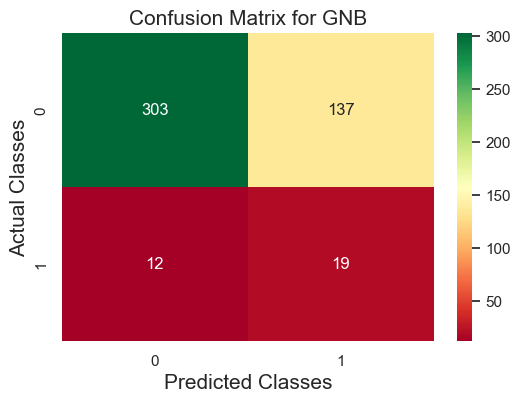

In [88]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB', fontsize = 15);

In [89]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.12      0.61      0.20        31
           0       0.96      0.69      0.80       440

    accuracy                           0.68       471
   macro avg       0.54      0.65      0.50       471
weighted avg       0.91      0.68      0.76       471



In [90]:
precision_nb, recall_nb, f1_score_nb, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_nb)
print('Recall Score :', '%0.2f' % recall_nb)
print('F1-Score:', '%0.2f' % f1_score_nb)
nb_acc= accuracy_score(Y_test, y_predictnb)
print('Accuracy Score :','%0.2f' % nb_acc)
print('AUC :','%0.2f' % roc_auc_nb)
print('Thresholdnb :','%0.2f' % 0.016)
Thresholdnb=0.016

Precision Score : 0.54
Recall Score : 0.65
F1-Score: 0.50
Accuracy Score : 0.85
AUC : 0.71
Thresholdnb : 0.02


----------

### Gaussian Naive Bayes on Under sampled Data

In [91]:
nbu = GaussianNB()
nbu.fit(X_under, y_under)

GaussianNB()

In [92]:
modelnbu_score = nbu.score(X_under,y_under)
print('Accuracy Score of Training Data: ', modelnbu_score)

Accuracy Score of Training Data:  0.7808219178082192


In [93]:
y_predictnbu= nbu.predict(X_test)
modelnbu_score = accuracy_score(Y_test, y_predictnbu)
print('Accuracy Score of Test Data:', modelnbu_score)

Accuracy Score of Test Data: 0.6560509554140127


In [94]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictnbu, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.12      0.68      0.21        31
           0       0.97      0.65      0.78       440

    accuracy                           0.66       471
   macro avg       0.54      0.67      0.49       471
weighted avg       0.91      0.66      0.74       471



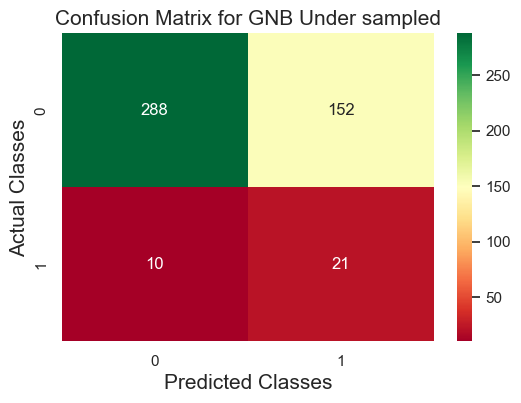

In [95]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictnbu)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB Under sampled', fontsize = 15);

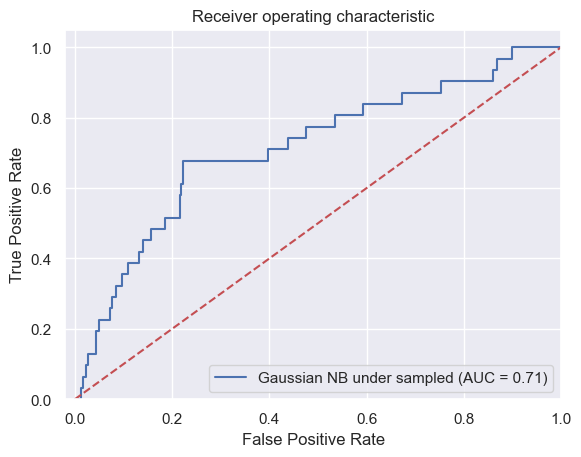

In [96]:
#Plotting ROC and AUC
probs = nbu.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_nbu = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='Gaussian NB under sampled (AUC = %0.2f)' % roc_auc_nbu)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [97]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
38  0.397727  0.677419  0.602273  0.075147   0.228381


In [99]:
# # store the predicted probabilities for failed class 
# y_pred_prob = nbu.predict_proba(X_test)[:, 1]
# # predict fail if the predicted probability is greater than 0.4753
# y_pred_class = binarize([y_pred_prob], 0.4753)[0]

from sklearn.preprocessing import binarize

# Store the predicted probabilities for the failed class
y_pred_prob = nbu.predict_proba(X_test)[:, 1]

# Reshape y_pred_prob to 2D array and predict fail if the predicted probability is greater than 0.4753
y_pred_class = binarize(y_pred_prob.reshape(-1, 1), threshold=0.4753)[:, 0]


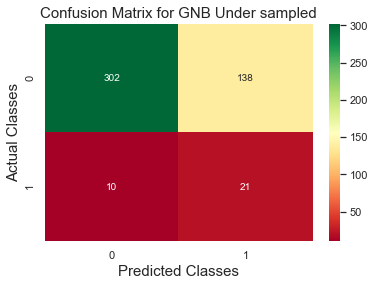

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB Under sampled', fontsize = 15);

In [ ]:
precision_nbu, recall_nbu, f1_score_nbu, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_nbu)
print('Recall Score :', '%0.2f' % recall_nbu)
print('F1-Score:', '%0.2f' % f1_score_nbu)
nbu_acc= accuracy_score(Y_test, y_predictnbu)
print('Accuracy Score :','%0.2f' % nbu_acc)
print('AUC :','%0.2f' % roc_auc_nbu)
print('Thresholdnbu:','%0.2f' % 0.4753)
Thresholdnbu=0.4753

Precision Score : 0.55
Recall Score : 0.68
F1-Score: 0.51
Accuracy Score : 0.69
AUC : 0.71
Thresholdnbu: 0.48


-----------

### LightGBM on Smote sampled Dataset

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

sample = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
lgb = LGBMClassifier(max_depth=-1, random_state=31, silent=True, metric='f1', n_jobs=4, n_estimators=2000)
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=sample,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_SMOTE, y_SMOTE)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.952164731370897,
 'min_child_samples': 111,
 'min_child_weight': 0.01,
 'num_leaves': 38,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.3029313662262354}

In [ ]:
lgb=LGBMClassifier(colsample_bytree=0.95,
 min_child_samples= 111,
 min_child_weight= 0.01,
 num_leaves= 38,
 reg_alpha= 0,
 reg_lambda= 0.1,
 subsample=0.30)
lgb.fit(X_SMOTE,y_SMOTE)

LGBMClassifier(colsample_bytree=0.95, min_child_samples=111,
               min_child_weight=0.01, num_leaves=38, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3)

In [ ]:
modellgb1=lgb.score(X_SMOTE,y_SMOTE)
print('Accuracy Score of Training Data: ', modellgb1)

Accuracy Score of Training Data:  1.0


In [ ]:
y_predictlg1= lgb.predict(X_test)
modellg1 = accuracy_score(Y_test, y_predictlg1)
print('Accuracy Score of Test Data:', modellg1)

Accuracy Score of Test Data: 0.9256900212314225


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictlg1, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.17      0.03      0.05        31
           0       0.94      0.99      0.96       440

    accuracy                           0.93       471
   macro avg       0.55      0.51      0.51       471
weighted avg       0.88      0.93      0.90       471



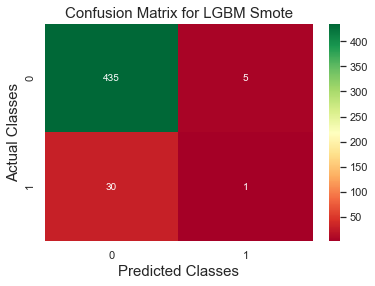

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictlg1)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LGBM Smote', fontsize = 15);

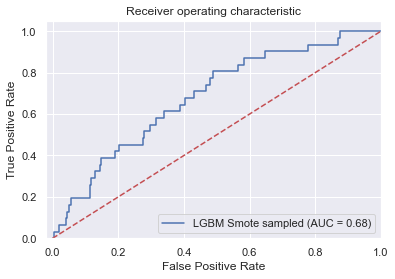

In [ ]:
#Plotting ROC and AUC
probs = lgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_lg = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBM Smote sampled (AUC = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr       tf  threshold
38  0.388636  0.612903  0.611364  0.00154   0.031447


In [ ]:
# store the predicted probabilities for failed class 
y_pred_prob = lgb.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.0314
y_pred_class = binarize([y_pred_prob], 0.0314)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.10      0.61      0.17        31
           0       0.96      0.61      0.75       440

    accuracy                           0.61       471
   macro avg       0.53      0.61      0.46       471
weighted avg       0.90      0.61      0.71       471



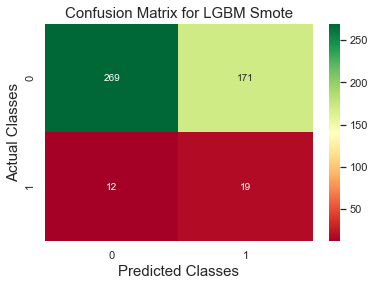

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LGBM Smote', fontsize = 15);

In [ ]:
precision_lg, recall_lg, f1_score_lg, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_lg)
print('Recall Score :', '%0.2f' % recall_lg)
print('F1-Score:', '%0.2f' % f1_score_lg)
lg_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % lg_acc)
print('AUC :','%0.2f' % roc_auc_lg)
print('Thresholdlg :','%0.2f' % 0.0314)
Thresholdlg=0.0314

Precision Score : 0.53
Recall Score : 0.61
F1-Score: 0.46
Accuracy Score : 0.61
AUC : 0.68
Thresholdlg : 0.03


-------------

### RandomForest on Random over sampled Dataset

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(2,100,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)
rf_random.fit(X_over, y_over)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [ ]:
rf_grid1 = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)
rf_grid1.fit(X_over, y_over)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [ ]:
modelrfg1_score=rf_grid1.score(X_over,y_over)
print('Accuracy Score of Training Data: ', modelrfg1_score)

Accuracy Score of Training Data:  0.9980443285528031


In [ ]:
y_predictrfg1= rf_grid1.predict(X_test)
modelrfg1_score = accuracy_score(Y_test, y_predictrfg1)
print('Accuracy Score of Test Data:', modelrfg1_score)

Accuracy Score of Test Data: 0.9341825902335457


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictrfg1, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



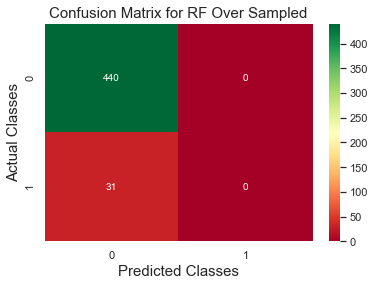

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictrfg1)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF Over Sampled', fontsize = 15);

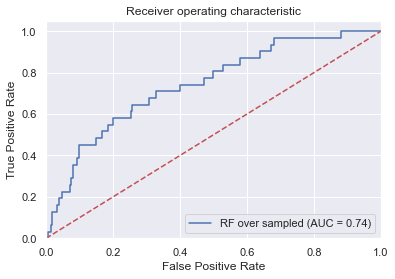

In [ ]:
#Plotting ROC and AUC
probs = rf_grid1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_rfo = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RF over sampled (AUC = %0.2f)' % roc_auc_rfo)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
35  0.272727  0.709677  0.727273 -0.017595   0.168882


In [ ]:
# store the predicted probabilities  for failed class 
y_pred_prob = rf_grid1.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.1688
y_pred_class = binarize([y_pred_prob], 0.1688)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.15      0.71      0.25        31
           0       0.97      0.73      0.83       440

    accuracy                           0.73       471
   macro avg       0.56      0.72      0.54       471
weighted avg       0.92      0.73      0.79       471



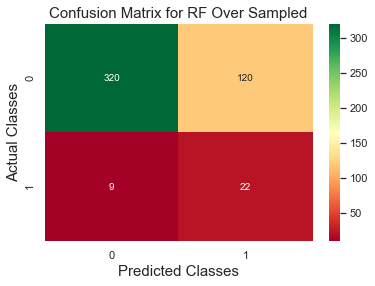

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF Over Sampled', fontsize = 15);

In [ ]:
precision_rfo, recall_rfo, f1_score_rfo, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_rfo)
print('Recall Score :', '%0.2f' % recall_rfo)
print('F1-Score:', '%0.2f' % f1_score_rfo)
rfo_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % rfo_acc)
print('AUC :','%0.2f' % roc_auc_rfo)
print('Thresholdrf :','%0.2f' % 0.1688)
Thresholdrf=0.1688

Precision Score : 0.56
Recall Score : 0.72
F1-Score: 0.54
Accuracy Score : 0.73
AUC : 0.76
Thresholdrf : 0.17


### LightGBM on ADASYN sampled Dataset

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

sample = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
lgb = LGBMClassifier(max_depth=-1, random_state=31, silent=True, metric='f1', n_jobs=4, n_estimators=2000)
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=sample,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_adasyn, y_adasyn)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.952164731370897,
 'min_child_samples': 111,
 'min_child_weight': 0.01,
 'num_leaves': 38,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.3029313662262354}

In [ ]:
lgb=LGBMClassifier(colsample_bytree=0.95,
 min_child_samples= 111,
 min_child_weight= 0.01,
 num_leaves= 38,
 reg_alpha= 0,
 reg_lambda= 0.1,
 subsample=0.30)
lgb.fit(X_adasyn,y_adasyn)

LGBMClassifier(colsample_bytree=0.95, min_child_samples=111,
               min_child_weight=0.01, num_leaves=38, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3)

In [ ]:
modellgb=lgb.score(X_adasyn,y_adasyn)
print('Accuracy Score of Training Data: ', modellgb)

Accuracy Score of Training Data:  1.0


In [ ]:
y_predictlg= lgb.predict(X_test)
modellg = accuracy_score(Y_test, y_predictlg)
print('Accuracy Score of Test Data:', modellg)

Accuracy Score of Test Data: 0.9256900212314225


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictlg, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      0.99      0.96       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



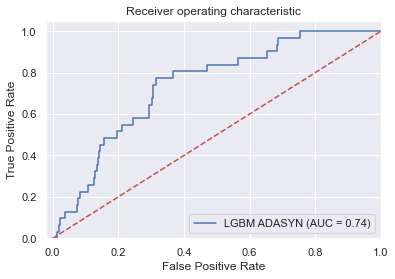

In [ ]:
#Plotting ROC and AUC
probs = lgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_lg1 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBM ADASYN (AUC = %0.2f)' % roc_auc_lg1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
43  0.304545  0.709677  0.695455  0.014223   0.041761


In [ ]:
# store the predicted probabilities for failed class 
y_pred_prob = lgb.predict_proba(X_test)[:, 1]
# predict fail for predicted probability is greater than 0.04176
y_pred_class = binarize([y_pred_prob], 0.0417)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.14      0.71      0.24        31
           0       0.97      0.70      0.81       440

    accuracy                           0.70       471
   macro avg       0.56      0.70      0.52       471
weighted avg       0.92      0.70      0.77       471



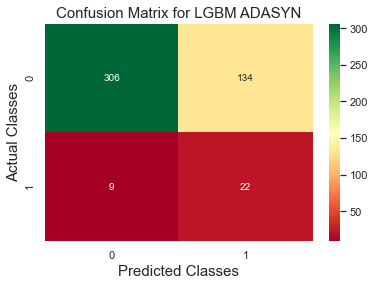

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LGBM ADASYN', fontsize = 15);

In [ ]:
precision_lg1, recall_lg1, f1_score_lg1, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_lg1)
print('Recall Score :', '%0.2f' % recall_lg1)
print('F1-Score:', '%0.2f' % f1_score_lg1)
lg1_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % lg1_acc)
print('AUC :','%0.2f' % roc_auc_lg1)
print('Thresholdlg1 :','%0.2f' % 0.0417)
Thresholdlg1=0.0417

Precision Score : 0.56
Recall Score : 0.70
F1-Score: 0.52
Accuracy Score : 0.70
AUC : 0.74
Thresholdlg1 : 0.04


In [ ]:
modellists = []
modellists.append(['Gaussian NB Normal Data', nb_acc * 100, recall_nb * 100, precision_nb * 100,roc_auc_nb*100,f1_score_nb*100,Thresholdnb])
modellists.append(['Gausian NB under samples data', nbu_acc* 100, recall_nbu * 100, precision_nbu* 100,roc_auc_nbu*100,f1_score_nbu*100,Thresholdnbu])
modellists.append(['LGBM Smote sampled Data', lg_acc * 100, recall_lg * 100, precision_lg * 100,roc_auc_lg*100,f1_score_lg*100,Thresholdlg])
modellists.append(['Random Forest Over sampled Data', rfo_acc * 100, recall_rfo * 100, precision_rfo * 100,roc_auc_rfo*100,f1_score_rfo*100,Thresholdrf])
modellists.append(['LGBM ADASYN sampled Data', lg1_acc * 100, recall_lg1 * 100, precision_lg1 * 100,roc_auc_lg1*100,f1_score_lg1*100,Thresholdlg1])
model_df = pd.DataFrame(modellists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','AUC','F1 Score','Threshold'])
model_df

Model  Accuracy Scores on Test  Recall Score  \
0          Gaussian NB Normal Data                84.713376     70.256598   
1    Gausian NB under samples data                68.577495     68.189150   
2          LGBM Smote sampled Data                61.146497     61.213343   
3  Random Forest Over sampled Data                72.611465     71.847507   
4         LGBM ADASYN sampled Data                69.639066     70.256598   

   Precision Score        AUC   F1 Score  Threshold  
0        55.622711  73.196481  52.294507     0.0160  
1        55.001209  70.689150  51.212206     0.4753  
2        52.864769  68.218475  45.906578     0.0314  
3        56.378698  75.916422  54.329247     0.1688  
4        55.622711  74.024927  52.294507     0.0417

-----------

### Fitting the resuts on the validation/future dataset

In [ ]:
#making copies of validation dataset
val1=val.copy()
val1=val1.reset_index(drop=True)
val1=pd.DataFrame(val1)
val2=val.copy()
val2=val2.reset_index(drop=True)
val2=pd.DataFrame(val2)
val3=val.copy()
val3=val3.reset_index(drop=True)
val3=pd.DataFrame(val3)
val4=val.copy()
val4=val4.reset_index(drop=True)
val4=pd.DataFrame(val4)

In [ ]:
#Fitting Random forest
rf_grid1.fit(X_over, y_over)
pred=rf_grid1.predict(val1)
val1['Pass/Fail'] = pred
val1 = val1[(val1['Pass/Fail'] == 1)]
val1.head()

0         1         2         3        4         8         9  \
11 -1.30503 -0.295197 -0.196644  0.787541 -0.89971  0.065423  1.319303   

          10        11     14        15        16        19        20  \
11 -1.870629 -2.187508  0.055  0.872225  0.615534  0.386885  1.135829   

         21        23        24        25        28        29        31  \
11 -0.97941 -0.031442  0.515958 -2.423074 -1.348142 -0.791661  1.526909   

          32        33        36        40        41        43        44  \
11  0.350516  2.317848 -0.424897 -0.064749  0.332195  0.855194 -1.800897   

          45        47        53        59        60        62        63  \
11  0.975184  0.079905  1.276967  0.094912  1.248753  2.000396 -0.920018   

          64        67        71        72        75        76        77  \
11 -1.304138 -0.502127 -1.787665 -0.971501 -0.909473 -2.083356  0.482763   

          78        79        80        81       82        83        84  \
11  0.518936  0.222525  0.444581 -0.691323  0.62356 -1.636567 -0.237128   

          86        87       88       89       90        91      92       93  \
11 -1.287214 -1.447789 -0.01461  0.69252 -0.07639 -0.071476 -2.1833  0.86197   

          94        95        99       100      102       103       107  \
11  0.196065 -0.685447  0.013117  0.071631  0.04062  1.444477 -0.016233   

         108       109       112       113      115       116       117  \
11  0.202395 -0.727914  0.968889 -0.948976 -0.57047 -0.828552  1.248833   

         118       119       120       121       122       126       129  \
11 -0.034356 -1.026351 -0.097427  0.887994 -1.402825  0.290266 -0.587076   

        130       134       135       136       137       138       139  \
11  0.71748  2.304036  0.587452 -0.459007  0.546485 -0.617087 -0.668174   

         142      143       144       145       146       150       151  \
11 -0.429481  0.73671  0.116571  2.334591 -1.154209 -0.666745  0.087319   

       153       155       156       159       160       161      162  \
11  1.1083  1.113267 -0.664708 -0.075114  0.750902 -1.175998 -0.76128   

         166       167      168       169      170       171       172  \
11 -0.487023 -0.742421 -1.61883 -1.607628 -1.11917  0.063005  1.618044   

        173       175       176       177       180       181       182  \
11 -0.59743  0.771738  0.042392 -0.662651 -1.256061 -0.647066  0.780113   

         183       184       188       195       200       201       208  \
11  1.454023  0.111617  1.405453 -0.246536 -0.789565 -1.706823  0.049191   

         210       211       212       213       214       215       216  \
11  2.565222  1.111234  1.493219  1.109714  0.693491 -1.563959 -2.182179   

         217      218       219       221      222       223       225  \
11 -0.250519  0.25034 -1.992389  0.577076  0.43486 -0.467304 -0.572257   

        227       228       238       239       244       247       250  \
11 -0.06857 -0.132303 -0.497814  2.289562 -0.580445  1.837681 -1.350979   

         251       253       255       267       268      269       345  \
11 -1.154603  0.048101  0.467965 -1.161192  1.064915  0.43864 -0.875779   

         418      419       423       432       433       438       460  \
11  0.869232 -0.21969 -0.901517 -1.115397 -0.875037 -0.387987  0.639047   

         468       472       476       482       483       484       485  \
11 -0.977465  0.219717 -0.157392  1.059078 -0.727031 -1.156699 -1.022856   

         486      487       488       489       499       500       510  \
11 -1.034019 -0.89954 -0.808767  0.105296  2.073032 -0.744957  1.018369   

         511       542       543       544       546       558       559  \
11 -0.834202 -0.582912 -0.374845  0.365666  0.928824  2.083586  0.606205   

         562       565       570       571       572       578       582  \
11  0.198621 -0.298067  0.416107  0.241773 -0.534322  2.526623 -0.426818   

         583       586       587       589  Pass/Fail  
11 -0.027964  

In [ ]:
#fitting Random Forest with threshold
# store the predicted probabilities  for failed class 
y_pred_prob = rf_grid1.predict_proba(val2)[:, 1]
# predict fail if the predicted probability is greater than 0.1688
pred = binarize([y_pred_prob], 0.1688)[0]
val2['Pass/Fail'] = pred
val2 = val2[(val2['Pass/Fail'] == 1)]
val2.head(18)

0         1         2         3         4         8         9  \
0   0.344218  1.114103 -0.524446  0.204352  0.195255  0.501801  1.261706   
2  -1.244126  1.046470 -0.575570  1.063986  0.646105 -0.286450  0.390554   
8  -0.677576  1.721635  1.840620 -1.014149 -1.523386  0.990821  0.894526   
10 -0.251573  0.851067 -0.238748 -0.889267  0.075629  0.694362 -1.272553   
11 -1.305030 -0.295197 -0.196644  0.787541 -0.899710  0.065423  1.319303   
14 -0.737510  2.204895  0.901897 -1.184030 -0.008529 -0.233807  1.132113   
15 -0.344301  0.818583  0.901897 -1.184030 -0.008529  1.139051  1.895271   

          10        11        14        15        16        19        20  \
0  -0.425113 -2.078819 -0.373819  0.275959  0.446257  0.271668 -0.244093   
2   0.141048 -0.339807  0.206534  0.493627 -1.323982  0.609427  0.483365   
8  -0.810584 -1.654935  1.385175  0.599515 -0.376325  0.386885  1.645800   
10  0.141048 -2.317934  1.077456 -0.069394  1.049776 -0.560103  1.023335   
11 -1.870629 -2.187508  0.055000  0.872225  0.615534  0.386885  1.135829   
14 -1.449020 -0.698478  0.295974  1.164467 -0.187133 -0.687946 -0.221595   
15 -0.304653 -0.328938  1.293168  1.447275 -0.650519 -0.624814  0.220880   

          21        23        24        25        28        29        31  \
0   0.553955 -0.271451  0.515147 -2.475967 -1.501610 -0.905916  1.492211   
2   0.489006 -0.275934 -0.926830  0.672706 -0.667230 -0.107159  2.553189   
8   0.322962  1.239982  0.445818  0.450554 -1.913996 -0.592164  1.326725   
10  0.322962  2.580719  0.304053  0.450554 -0.213269 -1.105669  1.276011   
11 -0.979410 -0.031442  0.515958 -2.423074 -1.348142 -0.791661  1.526909   
14  0.322962  0.036146  0.180397  0.450554 -2.000311  0.121094  0.707487   
15  0.322962  2.474508  0.153098  0.450554 -2.364762 -0.335412  0.989080   

          32        33        36        40        41        43        44  \
0  -1.914492  2.002942 -1.050316 -0.064749  2.733885 -0.455997  0.925689   
2  -0.397495 -0.423080  1.222153 -0.064749  0.060201  1.438211 -1.003934   
8   0.350516  2.317848 -0.424897 -0.064749  0.332195  0.557489 -1.597713   
10 -0.397495 -0.423080  1.222153 -0.064749  0.060201  1.726755  1.814780   
11  0.350516  2.317848 -0.424897 -0.064749  0.332195  0.855194 -1.800897   
14 -0.023434  1.116489  1.041433 -1.335374 -2.019537 -0.199795 -1.065773   
15 -0.023434  1.116489  1.041433 -1.335374 -2.019537 -0.467660 -1.357930   

          45        47        53        59        60        62        63  \
0  -0.839151  0.685231 -0.152223 -0.604676 -0.738225 -1.278132  0.712533   
2  -0.646612  0.642937 -0.022297  0.094912  1.597074 -0.151153 -0.467066   
8   0.817067 -0.028472  1.276967  0.094912  0.535105  2.116279 -1.061592   
10 -2.193923 -1.180442  1.634265  0.094912  1.657748 -1.362616 -1.305984   
11  0.975184  0.079905  1.276967  0.094912  1.248753  2.000396 -0.920018   
14  0.223319 -1.481255 -1.256597  0.094912 -0.328766 -0.104216 -0.728826   
15  0.628920 -1.450064 -0.509520  0.094912 -0.549959  0.832062 -1.765415   

          64        67        71        72        75        76        77  \
0   0.463593 -0.517187 -0.762499 -0.971501  1.009951  0.253681  0.800331   
2  -0.977303 -1.051308 -0.727803  0.872552 -0.112005 -0.124787  0.119324   
8  -1.796170 -0.664773 -1.250098 -0.971501 -0.167003 -0.746104 -1.916637   
10 -2.018940 -1.053316  0.647876  1.014438  0.509471 -0.768181  0.313394   
11 -1.304138 -0.502127 -1.787665 -0.971501 -0.909473 -2.083356  0.482763   
14  0.628529  0.404472 -1.031013  1.016717 -0.513489 -1.042570  0.443949   
15 -0.093801 -0.718988  0.648455  1.122547 -0.265999 -0.862798  0.228709   

          78        79        80        81        82        83        84  \
0  -0.364710 -0.476870  0.389503 -0.067761 -0.267100 -0.476291 -0.237128   
2   0.813485 -0.304985 -2.051569  0.043921  0.837051 -0.701521  0.635055   
8   0.482684 -0.263495 -1.624161 -0.598254  0.900431  0.363404  0.801185   
10 -0.600349  0.003223 -1.747537  1.840152  1.067221 

In [ ]:
#fiiting naive bayes on validation dataset
nb = GaussianNB()
nb.fit(X_train, Y_train)
pred=nb.predict(val3)
val3['Pass/Fail'] = pred
val3 = val3[(val3['Pass/Fail'] == 1)]
val3.head(18)

0         1         2         3         4         8         9  \
2  -1.244126  1.046470 -0.575570  1.063986  0.646105 -0.286450  0.390554   
5  -1.023774 -1.070812  1.240011 -0.049162  0.715837  0.892463  1.297704   
7   0.795746  0.037138  1.840620 -1.014149 -1.523386  0.706830  1.225708   
8  -0.677576  1.721635  1.840620 -1.014149 -1.523386  0.990821  0.894526   
10 -0.251573  0.851067 -0.238748 -0.889267  0.075629  0.694362 -1.272553   
11 -1.305030 -0.295197 -0.196644  0.787541 -0.899710  0.065423  1.319303   
12 -1.446708  0.171238 -0.238748 -0.889267  0.075629  0.924326 -1.769325   
14 -0.737510  2.204895  0.901897 -1.184030 -0.008529 -0.233807  1.132113   
15 -0.344301  0.818583  0.901897 -1.184030 -0.008529  1.139051  1.895271   

          10        11        14        15        16        19        20  \
2   0.141048 -0.339807  0.206534  0.493627 -1.323982  0.609427  0.483365   
5   0.646979  0.573175 -0.111192  0.201479 -1.494716 -0.130802 -1.669013   
7   0.068772 -1.796230  1.758523 -0.490802 -0.427326  0.386885  0.250879   
8  -0.810584 -1.654935  1.385175  0.599515 -0.376325  0.386885  1.645800   
10  0.141048 -2.317934  1.077456 -0.069394  1.049776 -0.560103  1.023335   
11 -1.870629 -2.187508  0.055000  0.872225  0.615534  0.386885  1.135829   
12  2.586380 -0.557183 -0.177751  0.352703 -0.871526 -1.312958 -1.579018   
14 -1.449020 -0.698478  0.295974  1.164467 -0.187133 -0.687946 -0.221595   
15 -0.304653 -0.328938  1.293168  1.447275 -0.650519 -0.624814  0.220880   

          21        23        24        25        28        29        31  \
2   0.489006 -0.275934 -0.926830  0.672706 -0.667230 -0.107159  2.553189   
5  -0.889611 -0.082134  0.213913 -2.494858 -2.035470 -1.904426  1.504222   
7   0.607044  0.037526 -0.289225  0.792095 -0.619267  1.062605  0.687469   
8   0.322962  1.239982  0.445818  0.450554 -1.913996 -0.592164  1.326725   
10  0.322962  2.580719  0.304053  0.450554 -0.213269 -1.105669  1.276011   
11 -0.979410 -0.031442  0.515958 -2.423074 -1.348142 -0.791661  1.526909   
12  0.322962 -0.186620 -0.935884  0.614524 -1.747752  1.148104  1.635009   
14  0.322962  0.036146  0.180397  0.450554 -2.000311  0.121094  0.707487   
15  0.322962  2.474508  0.153098  0.450554 -2.364762 -0.335412  0.989080   

          32        33        36        40        41        43        44  \
2  -0.397495 -0.423080  1.222153 -0.064749  0.060201  1.438211 -1.003934   
5   0.345942  2.388901 -0.866658 -0.064749 -0.024913  0.773681 -1.621691   
7  -1.366061 -0.224417 -0.322538 -0.119994 -0.678069  0.510966 -0.696002   
8   0.350516  2.317848 -0.424897 -0.064749  0.332195  0.557489 -1.597713   
10 -0.397495 -0.423080  1.222153 -0.064749  0.060201  1.726755  1.814780   
11  0.350516  2.317848 -0.424897 -0.064749  0.332195  0.855194 -1.800897   
12 -0.226139 -0.366522 -0.526277 -0.530875  0.060201  1.220248 -1.980735   
14 -0.023434  1.116489  1.041433 -1.335374 -2.019537 -0.199795 -1.065773   
15 -0.023434  1.116489  1.041433 -1.335374 -2.019537 -0.467660 -1.357930   

          45        47        53        59        60        62        63  \
2  -0.646612  0.642937 -0.022297  0.094912  1.597074 -0.151153 -0.467066   
5   0.757731  0.055057  1.276967  0.094912  0.860022  2.257381 -1.364420   
7   0.762485 -1.454293  1.276967  0.094912  0.842400  2.397919 -1.857540   
8   0.817067 -0.028472  1.276967  0.094912  0.535105  2.116279 -1.061592   
10 -2.193923 -1.180442  1.634265  0.094912  1.657748 -1.362616 -1.305984   
11  0.975184  0.079905  1.276967  0.094912  1.248753  2.000396 -0.920018   
12  0.099276  0.261238 -0.022297  0.094912  1.684584  0.551019 -0.535076   
14  0.223319 -1.481255 -1.256597  0.094912 -0.328766 -0.104216 -0.728826   
15  0.628920 -1.450064 -0.509520  0.094912 -0.549959  0.832062 -1.765415   

          64        67        71        72        75        76        77  \
2  -0.977303 -1.051308 -0.727803  0.872552 -0.112005 -0.124787  0.119324   
5  -2.137879 -0.516183 -1.453018 -0.971501  1.405936 -

In [ ]:
#fitting naive bayes with threshold
# store the predicted probabilities  for failed class 
y_pred_prob = nb.predict_proba(val4)[:, 1]
# predict fail if the predicted probability is greater than 0.1555
pred = binarize([y_pred_prob], 0.01)[0]
val4['Pass/Fail'] = pred
val4 = val4[(val4['Pass/Fail'] == 1)]
val4.head(19)

0         1         2         3         4         8         9  \
2  -1.244126  1.046470 -0.575570  1.063986  0.646105 -0.286450  0.390554   
3  -0.337678 -0.286868 -0.087521 -1.297836  0.075629  0.331406 -0.797380   
4   0.365381  0.095775  1.240011 -0.049162  0.715837  0.537820 -0.127817   
5  -1.023774 -1.070812  1.240011 -0.049162  0.715837  0.892463  1.297704   
7   0.795746  0.037138  1.840620 -1.014149 -1.523386  0.706830  1.225708   
8  -0.677576  1.721635  1.840620 -1.014149 -1.523386  0.990821  0.894526   
9   0.104803 -1.145275  1.840620 -1.014149 -1.523386  1.022684  1.240107   
10 -0.251573  0.851067 -0.238748 -0.889267  0.075629  0.694362 -1.272553   
11 -1.305030 -0.295197 -0.196644  0.787541 -0.899710  0.065423  1.319303   
12 -1.446708  0.171238 -0.238748 -0.889267  0.075629  0.924326 -1.769325   
14 -0.737510  2.204895  0.901897 -1.184030 -0.008529 -0.233807  1.132113   
15 -0.344301  0.818583  0.901897 -1.184030 -0.008529  1.139051  1.895271   
16  0.297207  1.061962  2.666353 -0.253108  0.299852 -0.380652  1.175311   
17  0.373297  0.344319  2.666353 -0.253108  0.299852  1.238795  1.679283   

          10        11        14        15        16        19        20  \
2   0.141048 -0.339807  0.206534  0.493627 -1.323982  0.609427  0.483365   
3  -0.413067 -0.187643  0.239833  1.155211 -0.405954 -0.372284 -0.356587   
4  -0.882859 -0.839773  0.597331  0.954089  1.163679 -0.446464 -1.279035   
5   0.646979  0.573175 -0.111192  0.201479 -1.494716 -0.130802 -1.669013   
7   0.068772 -1.796230  1.758523 -0.490802 -0.427326  0.386885  0.250879   
8  -0.810584 -1.654935  1.385175  0.599515 -0.376325  0.386885  1.645800   
9   0.574703 -2.241852  1.289968  0.097783 -0.376325  0.386885  0.948339   
10  0.141048 -2.317934  1.077456 -0.069394  1.049776 -0.560103  1.023335   
11 -1.870629 -2.187508  0.055000  0.872225  0.615534  0.386885  1.135829   
12  2.586380 -0.557183 -0.177751  0.352703 -0.871526 -1.312958 -1.579018   
14 -1.449020 -0.698478  0.295974  1.164467 -0.187133 -0.687946 -0.221595   
15 -0.304653 -0.328938  1.293168  1.447275 -0.650519 -0.624814  0.220880   
16 -0.461250 -0.252856  1.197962  1.948509 -1.602062 -0.405428 -0.671569   
17 -0.340791 -0.361545  0.386791  0.939878 -1.080389 -0.405428 -0.214095   

          21        23        24        25        28        29        31  \
2   0.489006 -0.275934 -0.926830  0.672706 -0.667230 -0.107159  2.553189   
3   0.442694 -0.921474 -0.786686  0.684041 -1.875643  0.691598 -0.346818   
4   0.424621 -0.193862  0.172424  0.495135 -1.904415  2.004117 -1.794820   
5  -0.889611 -0.082134  0.213913 -2.494858 -2.035470 -1.904426  1.504222   
7   0.607044  0.037526 -0.289225  0.792095 -0.619267  1.062605  0.687469   
8   0.322962  1.239982  0.445818  0.450554 -1.913996 -0.592164  1.326725   
9   0.692890 -0.089031  0.581502 -2.440453 -0.696002  0.007096  1.513564   
10  0.322962  2.580719  0.304053  0.450554 -0.213269 -1.105669  1.276011   
11 -0.979410 -0.031442  0.515958 -2.423074 -1.348142 -0.791661  1.526909   
12  0.322962 -0.186620 -0.935884  0.614524 -1.747752  1.148104  1.635009   
14  0.322962  0.036146  0.180397  0.450554 -2.000311  0.121094  0.707487   
15  0.322962  2.474508  0.153098  0.450554 -2.364762 -0.335412  0.989080   
16 -0.210186  0.265465 -1.212522  0.387837 -1.754140  1.519111  0.252401   
17  0.116819  0.316501  0.387437 -2.190342 -2.649286 -0.278156  3.440674   

          32        33        36        40        41        43        44  \
2  -0.397495 -0.423080  1.222153 -0.064749  0.060201  1.438211 -1.003934   
3  -0.226139 -0.366522 -0.526277 -0.530875  0.060201  1.218770 -0.674548   
4   1.354001 -0.114143  0.756885 -0.706967 -1.532908 -0.354845  2.345457   
5   0.345942  2.388901 -0.866658 -0.064749 -0.024913  0.773681 -1.621691   
7  -1.366061 -0.224417 -0.322538 -0.119994 -0.678069  0.510966 -0.696002   
8   0.350516  2.317848 -0.424897 -0.064749  0.332195  0.557489 -1.597713   
9  -1.366061 -0.224417 -0.322538 -0.119994 -0.678069  0.

### Observations:
1) Gaussian Naive bayes without any sampling gives a sensitivity of 48% with a type 2 error rate of 52%, while predicting 9 observation to have failed, adding  &emsp; a threshold of 0.016 gives a sensitivity of 71% and reduces type 2 error rate by 23% with and increase in type 1 error rate by 17% while predicting 14  <br/> &emsp;observations to have failed. <br/>
2) Random Forest with Randomly over sampled data gives 100% specificity and type 2 error while predicting 1 observation to have failed, adding a threshold &emsp;  of 0.1688 gives a sensitivity of 71% and type 2 error rate reduces by 71% with and increase in type 1 error rate by 27% while predicting 7 observations as <br/> &emsp;  failed. <br/>
3) Futher more we could have tried modeling the data based on only the important variable from variable importance plot to check if performance of the model  &emsp; increases.



-------------------

## PCA to check if the dimensions can be reduced future more and rebuild the models as above

In [ ]:
#Load the data and pre-processing for pca
com=pd.read_csv('./signal-data+Future.csv')
com=com.drop(['Time'],axis=1)
#dropping the columns the have constant signal
cols = com.select_dtypes([np.number]).columns
std = com[cols].std()
cols_to_drop = std[std==0].index
com.drop(cols_to_drop, axis=1,inplace=True)
#label encoding the target class
com['Pass/Fail']=com['Pass/Fail'].replace([-1,1],[0,1])
#replacing the NaN/NA with zero and considering it as no signal
com.fillna(0,inplace=True)
row,column=com.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 1585 rows and 475 columns


In [ ]:
sg=com.iloc[0:1567,:]
y=sg['Pass/Fail']
sg=sg.drop(['Pass/Fail'],axis=1)
row,column=sg.shape
print('The past dataset contains', row, 'rows and', column, 'columns')

The past dataset contains 1567 rows and 474 columns


In [ ]:
val=com.iloc[1567:1586,:]
val=val.drop(['Pass/Fail'],axis=1)
row,column=val.shape
print('The validation dataset contains', row, 'rows and', column, 'columns')

The validation dataset contains 18 rows and 474 columns


In [ ]:
#scaling with z-score
comScaled= com.apply(zscore)  
#dropping NaN
comScaled.dropna(axis=1,inplace=True)
comScaled=comScaled.drop(['Pass/Fail'],axis=1)

In [ ]:
#splitting the dataset into train and validation set
X=comScaled.iloc[0:1567,:]
val=comScaled.iloc[1567:,:]
X.shape,val.shape

((1567, 474), (18, 474))

In [ ]:
from sklearn.decomposition import PCA
#extracting componenets that explaint 95% of the variation
pca = PCA(.95)
pca_ = pca.fit_transform(X)
pca

PCA(n_components=0.95)

In [ ]:
X_pca = pca.transform(X)  # PCs for the train data
val_pca = pca.transform(val)    # PCs for the test data

X_pca.shape, val_pca.shape

((1567, 158), (18, 158))

In [ ]:
pca.explained_variance_

array([26.16675992, 18.06107703, 13.70927143, 12.29759902, 10.68546427,
        9.95331148,  9.35729925,  8.64823007,  8.08850525,  7.79321193,
        7.09249305,  6.72414102,  6.62861272,  6.40165754,  6.21690301,
        6.11813448,  5.98425001,  5.64375621,  5.52390322,  5.32483464,
        5.24356088,  5.11652015,  4.89806327,  4.87611358,  4.78524547,
        4.55731408,  4.55014951,  4.51054696,  4.41780524,  4.31966871,
        4.19704364,  4.10602219,  4.00232687,  3.80286722,  3.76971573,
        3.65748448,  3.59958841,  3.52983411,  3.48399387,  3.44072958,
        3.353488  ,  3.2958605 ,  3.2225608 ,  3.15668446,  3.11604997,
        3.04538131,  3.03512913,  2.95745781,  2.92179189,  2.89733894,
        2.83098572,  2.75049517,  2.73566038,  2.68415761,  2.64588815,
        2.58646971,  2.52657042,  2.46606138,  2.41574704,  2.40307721,
        2.39838111,  2.34932852,  2.33184995,  2.30230267,  2.23268507,
        2.20141171,  2.16673249,  2.12754602,  2.11916282,  2.07

In [ ]:
#creating a dataframe of the componenets and attaching it to the target class
pca_df = pd.DataFrame(data = X_pca)
df=pd.concat([pca_df,y],axis=1)
df.head()

0         1         2         3         4         5         6  \
0 -1.391640  5.150359  3.178877 -0.466964  0.901184 -1.780250  0.701285   
1 -1.955984  3.285026  2.729192 -0.736846  1.736133 -2.657830 -0.236804   
2  0.278925  1.937571 -0.139066 -0.186996  0.000854  0.101144 -0.758327   
3  0.528330  2.175852 -1.693965  2.652302 -0.684325 -0.241593 -5.150900   
4  0.308119  4.417323  1.840441  0.612236  0.162877  0.119498  0.332537   

          7         8          9        10         11        12        13  \
0  1.120895 -1.294508   1.767426 -0.146152   2.210787  0.135200  0.988529   
1  0.009248 -3.098927   1.509108  0.131649   1.334124  0.020333  3.240083   
2 -1.667386 -2.252920   2.142752  2.455236   0.437368 -2.035598 -0.054022   
3 -2.631122 -0.789310  19.651834  6.584746 -16.192337  2.054759  4.486971   
4 -0.272154  2.250630   3.170334  0.735757  -3.247212  2.283609  1.366154   

         14        15        16        17        18        19        20  \
0  0.098269 -0.655160  0.175537  0.054897  4.686229 -0.510988 -5.115006   
1 -0.852073 -1.279149  0.349486  0.736332  1.517208 -2.377710 -2.642578   
2  1.944307 -0.535901 -0.304464  2.705936  0.239632 -1.213717  0.620981   
3 -3.775697 -2.448522  8.783194 -3.880678  0.783646 -3.280692 -2.298974   
4 -4.941261 -1.902437  0.676186 -1.913984  0.035088 -4.566823 -0.578037   

         21        22        23        24        25        26        27  \
0  6.439160  2.656116 -1.177485 -0.392285 -0.442233  0.147694  2.816576   
1  4.540764  1.884094 -0.195184  0.271020 -1.853049 -1.146654 -0.171979   
2 -0.030675  2.557970 -1.608922  0.505562  3.201052 -0.882069 -4.635498   
3  3.412294 -0.903023 -3.117263 -2.773727 -1.780158 -3.333509 -4.022592   
4 -2.066076  0.449146 -4.381404  0.436853 -4.109056  1.588612  3.023159   

         28        29        30        31        32        33        34  \
0 -0.323780 -2.897327 -0.654170  2.386776  1.246300  2.452147  5.629562   
1 -0.275408 -1.564530  1.178068  2.759176 -0.312723 -4.037480  1.287546   
2 -0.770801 -3.574428  1.330702  3.902943  2.544027 -0.020070 -3.531717   
3 -1.704069 -2.383513  7.680935  3.381884  5.684561 -1.292853  1.264532   
4  0.173118 -4.866134 -7.414828  1.337723 -2.863879  0.229513  2.787015   

         35        36        37        38        39        40        41  \
0 -0.493198 -3.588602  1.148772 -1.214649  0.078553 -0.714313 -0.446398   
1  0.637250  3.297083 -0.242817 -1.141758 -1.999374 -1.185483 -2.050356   
2 -3.183553 -0.405590  1.625177  2.049291 -2.147744 -3.378837 -1.741670   
3 -3.360697  1.710045 -0.020923  4.460400 -2.690661 -2.820947 -4.580525   
4  3.748061  4.825462 -4.503855  2.089468 -3.219903  2.476945 -6.941446   

         42        43        44        45        46        47        48  \
0  1.961985  0.267989  2.875115  0.084659 -0.631158 -0.947082 -1.341994   
1  1.790696  1.419176 -0.249398  0.793255 -1.079468  0.048519  0.705125   
2 -3.401969 -1.744007 -0.646464 -4.285466 -0.772173  3.050395 -4.472710   
3 -3.913600  2.091732 -0.830464  2.596260 -0.334023  2.606263  2.086205   
4 -2.260231  3.426524 -4.170843 -0.141279 -0.641335 -0.327460 -1.765326   

         49        50         51        52        53        54        55  \
0  0.153465  1.908460   1.849122  0.218385  2.557805 -0.149592 -2.618729   
1  1.732044  0.665385  -1.671489  0.688902 -1.849315  0.055338 -1.413829   
2  1.193505 -1.530343   0.710492  0.169889 -0.122648  1.196557 -1.207668   
3  3.209863  0.148541   6.099810  6.681021  0.368808 -2.113174  0.022069   
4 -2.993638 -2.476690 -10.101094  6.858996  0.445752  2.051620  0.507909   

         56        57        58         59        60        61        62  \
0  0.170473 -1.328606  2.293220   2.248078  1.966101  1.325839  1.440740   
1 -3.892635 -2.597456 -1.375360   1.250045  0.439314 -0.838653  3.043644   
2 -1.335390 -1.998037  0.611191  -0.713760 -1.868101  1.471241  2.605144   
3  2.088355 -6.347612 -2.159596   0.143957 -7.622815  6.896746  4.403907   
4 -2

In [ ]:
#seperating the DV and IDV
X=df.drop(['Pass/Fail'],axis=1)
y=df['Pass/Fail']

-----------------

## Trying various algorithms along with different sampling techniques

### Splitting the Past data into train and test 70:30 ratio

In [ ]:
# splitting data into training and test set for independent attributes
X_train, X_test, Y_train, Y_test =train_test_split(X,y, test_size=.30,random_state=105,stratify=y)

In [ ]:
print("Training Fail    : {0} ({1:0.2f}%)".format(len(Y_train[Y_train[:] == 1]), (len(Y_train[Y_train[:] == 1])/len(Y_train)) * 100))
print("Training Pass  : {0} ({1:0.2f}%)".format(len(Y_train[Y_train[:] == 0]), (len(Y_train[Y_train[:] == 0])/len(Y_train)) * 100))
print("")
print("Test Fail        : {0} ({1:0.2f}%)".format(len(Y_test[Y_test[:] == 1]), (len(Y_test[Y_test[:] == 1])/len(Y_test)) * 100))
print("Test Pass       : {0} ({1:0.2f}%)".format(len(Y_test[Y_test[:] == 0]), (len(Y_test[Y_test[:] == 0])/len(Y_test)) * 100))
print("")

Training Fail    : 73 (6.66%)
Training Pass  : 1023 (93.34%)

Test Fail        : 31 (6.58%)
Test Pass       : 440 (93.42%)



In [ ]:
# Initializaing various classification algorithms with normal dataset

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 18.810568% (18.008092%)
KNN: 0.000000% (0.000000%)
GNB: 16.255599% (7.081171%)
SVM: 18.793196% (12.056760%)
DT: 6.810967% (10.936352%)
RF: 0.000000% (0.000000%)
AB: 6.341991% (10.111747%)
GBT: 2.222222% (6.666667%)
XGB: 0.000000% (0.000000%)
LightGBM: 0.000000% (0.000000%)


-----------

### Random Undersampling

In [ ]:
# Implementing random under sampling
under= RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under= under.fit_sample(X_train, Y_train)

In [ ]:
print("Under Training Fail    : {0} ({1:0.2f}%)".format(len(y_under[y_under[:] == 1]), (len(y_under[y_under[:] == 1])/len(y_under)) * 100))
print("under Training Pass  : {0} ({1:0.2f}%)".format(len(y_under[y_under[:] == 0]), (len(y_under[y_under[:] == 0])/len(y_under)) * 100))


Under Training Fail    : 73 (33.33%)
under Training Pass  : 146 (66.67%)


In [ ]:
# Initializaing various classification algorithms with under sampled dataset

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=77,shuffle=True)
    cv_results = cross_val_score(model, X_under, y_under, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 39.451681% (18.770440%)
KNN: 36.588550% (14.558491%)
GNB: 36.821068% (19.109300%)
SVM: 39.952596% (15.831455%)
DT: 30.516817% (12.556153%)
RF: 15.521368% (16.508396%)
AB: 36.566688% (11.831624%)
GBT: 20.833056% (16.010799%)
XGB: 29.763015% (17.099830%)
LightGBM: 23.311577% (17.170448%)


----------

### Smote

In [ ]:
# Implementing SMOTE
smt = SMOTE(sampling_strategy=0.5)
X_SMOTE, y_SMOTE = smt.fit_sample(X_train, Y_train)

In [ ]:
print("SMOTE Training Fail    : {0} ({1:0.2f}%)".format(len(y_SMOTE[y_SMOTE[:] == 1]), (len(y_SMOTE[y_SMOTE[:] == 1])/len(y_SMOTE)) * 100))
print("SMOTE Training Pass  : {0} ({1:0.2f}%)".format(len(y_SMOTE[y_SMOTE[:] == 0]), (len(y_SMOTE[y_SMOTE[:] == 0])/len(y_SMOTE)) * 100))


SMOTE Training Fail    : 511 (33.31%)
SMOTE Training Pass  : 1023 (66.69%)


In [ ]:
# Initializaing various classification algorithms with smote sampled dataset

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=87,shuffle=True)
    cv_results = cross_val_score(model, X_SMOTE, y_SMOTE, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 78.727822% (4.429079%)
KNN: 61.857199% (1.104295%)
GNB: 60.929946% (3.225113%)
SVM: 81.435802% (3.034786%)
DT: 77.823108% (2.398956%)
RF: 94.866948% (3.099321%)
AB: 80.355898% (3.628175%)
GBT: 95.067420% (2.147922%)
XGB: 97.533985% (0.675093%)
LightGBM: 97.704184% (1.301273%)


-------------

### Random Oversampling

In [ ]:
# Implementing random over sampling
over= RandomOverSampler(sampling_strategy=0.5)
X_over, y_over= over.fit_sample(X_train, Y_train)

In [ ]:
print("over Training Fail    : {0} ({1:0.2f}%)".format(len(y_over[y_over[:] == 1]), (len(y_over[y_over[:] == 1])/len(y_over)) * 100))
print("over Training Pass  : {0} ({1:0.2f}%)".format(len(y_over[y_over[:] == 0]), (len(y_over[y_over[:] == 0])/len(y_over)) * 100))

over Training Fail    : 511 (33.31%)
over Training Pass  : 1023 (66.69%)


In [ ]:
# Initializaing various classification algorithms with over sampled dataset

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=9,shuffle=True)
    cv_results = cross_val_score(model, X_over, y_over, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 81.203355% (2.937267%)
KNN: 84.526860% (3.117029%)
GNB: 73.482276% (4.820808%)
SVM: 84.143746% (3.524154%)
DT: 92.537220% (2.209473%)
RF: 100.000000% (0.000000%)
AB: 90.873870% (4.018143%)
GBT: 99.413500% (0.655362%)
XGB: 99.708738% (0.444910%)
LightGBM: 100.000000% (0.000000%)


---------------

### ADASYN sampling

In [ ]:
oversample = ADASYN(sampling_strategy=0.5)
X_adasyn, y_adasyn = oversample.fit_resample(X_train, Y_train)

In [ ]:
print("ADASYN Training Fail    : {0} ({1:0.2f}%)".format(len(y_adasyn[y_adasyn[:] == 1]), (len(y_adasyn[y_adasyn[:] == 1])/len(y_adasyn)) * 100))
print("ADASYN Training Pass  : {0} ({1:0.2f}%)".format(len(y_adasyn[y_adasyn[:] == 0]), (len(y_adasyn[y_adasyn[:] == 0])/len(y_adasyn)) * 100))


ADASYN Training Fail    : 518 (33.61%)
ADASYN Training Pass  : 1023 (66.39%)


In [ ]:
# Initializaing various classification algorithms with ADASYN sampled dataset

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=23,shuffle=True)
    cv_results = cross_val_score(model, X_adasyn, y_adasyn, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 81.826688% (2.436621%)
KNN: 61.816419% (2.251760%)
GNB: 61.289878% (5.076775%)
SVM: 83.832082% (2.124327%)
DT: 79.303415% (4.189544%)
RF: 97.068778% (2.058335%)
AB: 81.576229% (3.886858%)
GBT: 95.587291% (2.221233%)
XGB: 98.354318% (1.387706%)
LightGBM: 98.120129% (1.448499%)


----------

### Logistic Regression with Normal dataset

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [1,2,4],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

lg=LogisticRegression()

log = GridSearchCV(lg, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
log.fit(X_train,Y_train)
log.best_estimator_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [ ]:
lg=LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')
lg.fit(X_train,Y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [ ]:
modellg= lg.score(X_train, Y_train)
print('Accuracy Score of Training Data: ', modellg)

Accuracy Score of Training Data:  0.9598540145985401


In [ ]:
y_predictlg= lg.predict(X_test)
modellg = accuracy_score(Y_test, y_predictlg)
print('Accuracy Score of Test Data:', modellg)

Accuracy Score of Test Data: 0.9129511677282378


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictlg, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.14      0.06      0.09        31
           0       0.94      0.97      0.95       440

    accuracy                           0.91       471
   macro avg       0.54      0.52      0.52       471
weighted avg       0.88      0.91      0.90       471



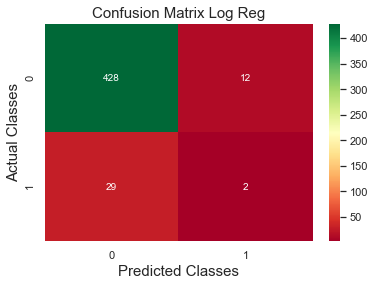

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictlg)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix Log Reg', fontsize = 15);

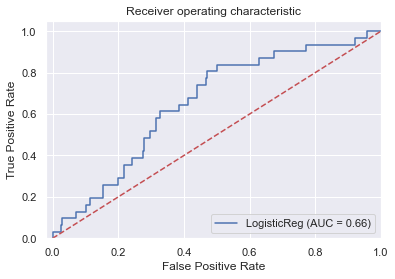

In [ ]:
#Plotting ROC and AUC
probs = lg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_lg = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LogisticReg (AUC = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
33  0.386364  0.612903  0.613636 -0.000733   0.036989


In [ ]:
# store the predicted probabilities for failed class 
y_pred_prob = lg.predict_proba(X_test)[:, 1]
# predict failed if the predicted probability is greater than 0.0376
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.0369)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.11      0.65      0.18        31
           0       0.96      0.61      0.75       440

    accuracy                           0.62       471
   macro avg       0.53      0.63      0.46       471
weighted avg       0.90      0.62      0.71       471



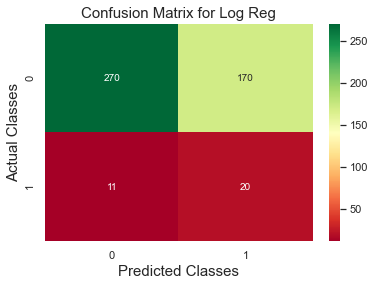

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for Log Reg', fontsize = 15);

In [ ]:
precision_lg, recall_lg, f1_score_lg, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_lg)
print('Recall Score :', '%0.2f' % recall_lg)
print('F1-Score:', '%0.2f' % f1_score_lg)
lg_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % lg_acc)
print('AUC :','%0.2f' % roc_auc_lg)
print('Threshold :','%0.2f' % 0.0376)
Thresholdlo=0.0376

Precision Score : 0.53
Recall Score : 0.63
F1-Score: 0.46
Accuracy Score : 0.62
AUC : 0.66
Threshold : 0.04


---------

### SVM with Under Sampled Dataset

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# Make grid search classifier
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# Train the classifier
svm_grid.fit(X_under, y_under)
svm_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}

In [ ]:
svc_cv = SVC(kernel = 'sigmoid', gamma = 0.001, C = 1,probability=True)
svc_cv.fit(X_under,y_under)

SVC(C=1, gamma=0.001, kernel='sigmoid', probability=True)

In [ ]:
modelsv_score = svc_cv.score(X_under, y_under)
print('Accuracy Score of Training Data: ', modelsv_score)

Accuracy Score of Training Data:  0.6940639269406392


In [ ]:
y_predictsv= svc_cv.predict(X_test)
modelsv_score = accuracy_score(Y_test, y_predictsv)
print('Accuracy Score of Test Data:', modelsv_score)

Accuracy Score of Test Data: 0.921443736730361


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictsv, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.25      0.10      0.14        31
           0       0.94      0.98      0.96       440

    accuracy                           0.92       471
   macro avg       0.59      0.54      0.55       471
weighted avg       0.89      0.92      0.90       471



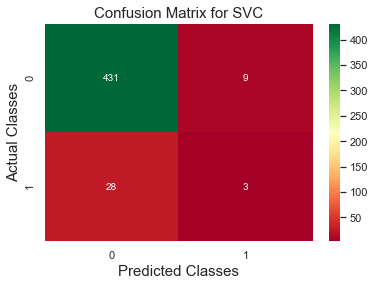

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictsv)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

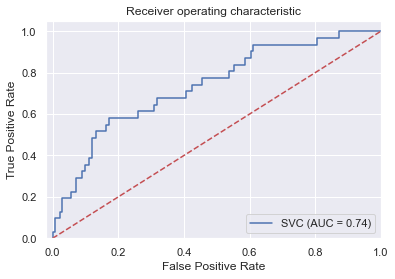

In [ ]:
#Plotting ROC and AUC
probs = svc_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_sv = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC = %0.2f)' % roc_auc_sv)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
34  0.318182  0.677419  0.681818 -0.004399   0.330785


In [ ]:
# store the predicted probabilities for failed class 
y_pred_prob = svc_cv.predict_proba(X_test)[:, 1]
# predict failed if the predicted probability is greater than 0.3307
y_pred_class = binarize([y_pred_prob], 0.3307)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.13      0.68      0.22        31
           0       0.97      0.68      0.80       440

    accuracy                           0.68       471
   macro avg       0.55      0.68      0.51       471
weighted avg       0.91      0.68      0.76       471



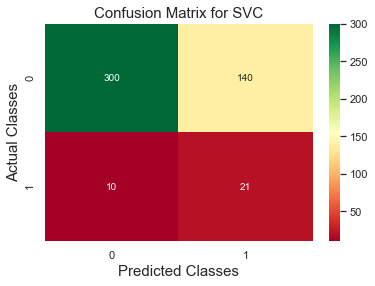

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

In [ ]:
precision_sv, recall_sv, f1_score_sv, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_sv)
print('Recall Score :', '%0.2f' % recall_sv)
print('F1-Score:', '%0.2f' % f1_score_sv)
sv_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % sv_acc)
print('AUC :','%0.2f' % roc_auc_sv)
print('Threshold :','%0.2f' % 0.3307)
Thresholdsv=0.3307

Precision Score : 0.55
Recall Score : 0.68
F1-Score: 0.51
Accuracy Score : 0.68
AUC : 0.74
Threshold : 0.33


----------------------------

### LightGBM with Smote Sampled Dataset

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

sample = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
lgb = LGBMClassifier(max_depth=-1, random_state=31, silent=True, metric='f1', n_jobs=4, n_estimators=2000)
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=sample,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_SMOTE, y_SMOTE)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.952164731370897,
 'min_child_samples': 111,
 'min_child_weight': 0.01,
 'num_leaves': 38,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.3029313662262354}

In [ ]:
lgb=LGBMClassifier(colsample_bytree=0.95,
 min_child_samples= 111,
 min_child_weight= 0.01,
 num_leaves= 38,
 reg_alpha= 0,
 reg_lambda= 0.1,
 subsample=0.30)
lgb.fit(X_SMOTE,y_SMOTE)

LGBMClassifier(colsample_bytree=0.95, min_child_samples=111,
               min_child_weight=0.01, num_leaves=38, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3)

In [ ]:
modellgbm=lgb.score(X_under,y_under)
print('Accuracy Score of Training Data: ', modellgbm)

Accuracy Score of Training Data:  1.0


In [ ]:
y_predictlgm= lgb.predict(X_test)
modellgm = accuracy_score(Y_test, y_predictlgm)
print('Accuracy Score of Test Data:', modellgm)

Accuracy Score of Test Data: 0.9341825902335457


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictlgm, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



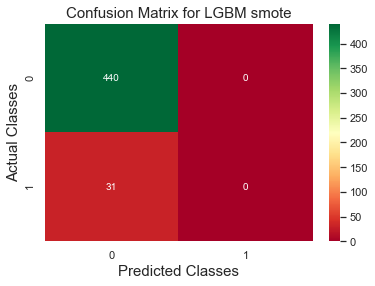

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictlgm)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LGBM smote', fontsize = 15);

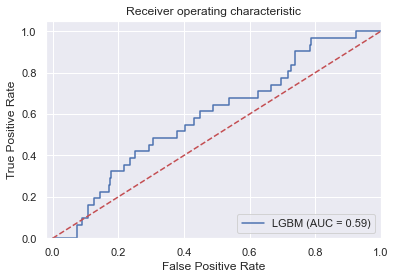

In [ ]:
#Plotting ROC and AUC
probs = lgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_lgm = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBM (AUC = %0.2f)' % roc_auc_lgm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
35  0.429545  0.580645  0.570455  0.010191   0.047767


In [ ]:
# store the predicted probabilities for diabetic class for all records... 
y_pred_prob = lgb.predict_proba(X_test)[:, 1]
# predict diabetes if the predicted probability is greater than 0.0441
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.0477)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.09      0.58      0.15        31
           0       0.95      0.57      0.71       440

    accuracy                           0.57       471
   macro avg       0.52      0.58      0.43       471
weighted avg       0.89      0.57      0.68       471



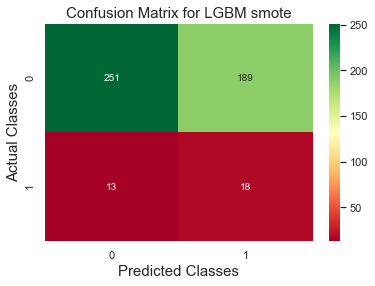

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LGBM smote', fontsize = 15);

In [ ]:
precision_lgm, recall_lgm, f1_score_lgm, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_lgm)
print('Recall Score :', '%0.2f' % recall_lgm)
print('F1-Score:', '%0.2f' % f1_score_lgm)
lgm_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % lgm_acc)
print('AUC :','%0.2f' % roc_auc_lgm)
print('Threshold :','%0.2f' % 0.0477)
Thresholdlg=0.0444

Precision Score : 0.52
Recall Score : 0.58
F1-Score: 0.43
Accuracy Score : 0.57
AUC : 0.59
Threshold : 0.05


---------------

### Random Forest with Over sampled Dataset

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(2,100,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)
rf_random.fit(X_over, y_over)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [ ]:
rf_grid1 = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)
rf_grid1.fit(X_over, y_over)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [ ]:
modelrfg1_score=rf_grid1.score(X_over,y_over)
print('Accuracy Score of Training Data: ', modelrfg1_score)

Accuracy Score of Training Data:  0.9954367666232073


In [ ]:
y_predictrfg1= rf_grid1.predict(X_test)
modelrfg1_score = accuracy_score(Y_test, y_predictrfg1)
print('Accuracy Score of Test Data:', modelrfg1_score)

Accuracy Score of Test Data: 0.9341825902335457


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictrfg1, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



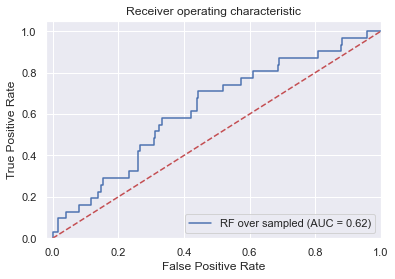

In [ ]:
#Plotting ROC and AUC
probs = rf_grid1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_rfo = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RF over sampled (AUC = %0.2f)' % roc_auc_rfo)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
33  0.422727  0.580645  0.577273  0.003372    0.15397


In [ ]:
# store the predicted probabilities  for failed class 
y_pred_prob = rf_grid1.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.1656
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.1539)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.09      0.58      0.15        31
           0       0.95      0.58      0.72       440

    accuracy                           0.58       471
   macro avg       0.52      0.58      0.44       471
weighted avg       0.89      0.58      0.68       471



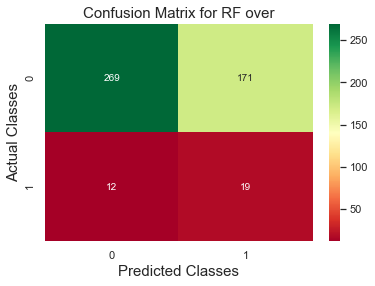

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF over', fontsize = 15);

In [ ]:
precision_rfo, recall_rfo, f1_score_rfo, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_rfo)
print('Recall Score :', '%0.2f' % recall_rfo)
print('F1-Score:', '%0.2f' % f1_score_rfo)
rfo_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % rfo_acc)
print('AUC :','%0.2f' % roc_auc_rfo)
print('Threshold :','%0.2f' % 0.1539)
Thresholdrf=0.1656

Precision Score : 0.52
Recall Score : 0.58
F1-Score: 0.44
Accuracy Score : 0.58
AUC : 0.62
Threshold : 0.15


----

### XGboost with ADASYN sampled Dataset

In [ ]:
xgb_para = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
           }

xgb = XGBClassifier()
xgb_hy = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_para, cv = 5, verbose=2, random_state=25, n_jobs = -1)
xgb_hy.fit(X_adasyn, y_adasyn)
xgb_hy.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.3}

In [ ]:
xgb=XGBClassifier(min_child_weight=5,
 max_depth=15,
 learning_rate= 0.2,
 gamma= 0.1,
 colsample_bytree=0.3)
xgb.fit(X_adasyn,y_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
modelxgb_score=xgb.score(X_adasyn,y_adasyn)
print('Accuracy Score of Training Data: ', modelxgb_score)

Accuracy Score of Training Data:  1.0


In [ ]:
y_predictxg= xgb.predict(X_test)
modelxg_score = accuracy_score(Y_test, y_predictxg)
print('Accuracy Score of Test Data:', modelxg_score)

Accuracy Score of Test Data: 0.9341825902335457


In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictxg, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.50      0.03      0.06        31
           0       0.94      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.72      0.51      0.51       471
weighted avg       0.91      0.93      0.91       471



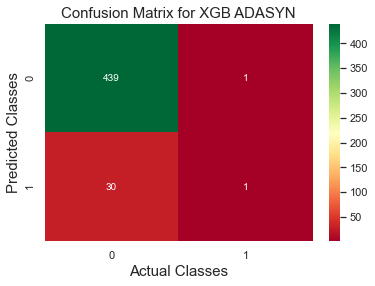

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_predictxg)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for XGB ADASYN', fontsize = 15);

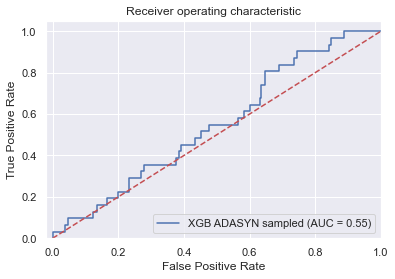

In [ ]:
#Plotting ROC and AUC
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_xg = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='XGB ADASYN sampled (AUC = %0.2f)' % roc_auc_xg)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
32  0.477273  0.516129  0.522727 -0.006598   0.019235


In [ ]:
# store the predicted probabilities for failed class 
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.0221
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.0192)[0]

In [ ]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.07      0.52      0.12        31
           0       0.94      0.52      0.67       440

    accuracy                           0.52       471
   macro avg       0.50      0.52      0.40       471
weighted avg       0.88      0.52      0.64       471



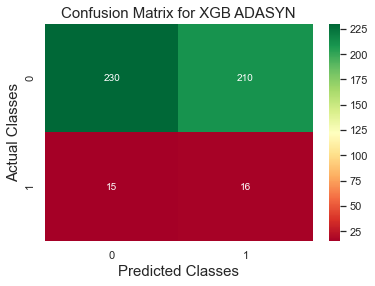

In [ ]:
# visualizing confusion matrix
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for XGB ADASYN', fontsize = 15);

In [ ]:
precision_xg, recall_xg, f1_score_xg, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_xg)
print('Recall Score :', '%0.2f' % recall_xg)
print('F1-Score:', '%0.2f' % f1_score_xg)
xg_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % xg_acc)
print('AUC :','%0.2f' % roc_auc_xg)
print('Threshold :','%0.2f' % 0.0192)
Thresholdxg=0.0192

Precision Score : 0.50
Recall Score : 0.52
F1-Score: 0.40
Accuracy Score : 0.52
AUC : 0.55
Threshold : 0.02


In [ ]:
modellists = []
modellists.append(['Logistic Normal Data', lg_acc * 100, recall_lg * 100, precision_lg * 100,roc_auc_lg*100,f1_score_lg*100,Thresholdlo])
modellists.append(['SVM Under sampled data', sv_acc* 100, recall_sv * 100, precision_sv* 100,roc_auc_sv*100,f1_score_sv*100,Thresholdsv])
modellists.append(['LGBM Smote sampled Data', lgm_acc * 100, recall_lgm * 100, precision_lgm * 100,roc_auc_lg*100,f1_score_lg*100,Thresholdlg])
modellists.append(['Random Forest Over sampled Data', rfo_acc * 100, recall_rfo * 100, precision_rfo * 100,roc_auc_rfo*100,f1_score_rfo*100,Thresholdrf])
modellists.append(['XGboost ADASYN sampled Data', xg_acc * 100, recall_xg * 100, precision_xg * 100,roc_auc_xg*100,f1_score_xg*100,Thresholdxg])
model_df = pd.DataFrame(modellists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','AUC','F1 Score','Threshold'])
model_df

Model  Accuracy Scores on Test  Recall Score  \
0             Logistic Normal Data                61.571125     62.939883   
1           SVM Under sampled data                68.152866     67.961877   
2          LGBM Smote sampled Data                57.112527     57.554985   
3  Random Forest Over sampled Data                57.749469     57.895894   
4      XGboost ADASYN sampled Data                52.229299     51.942815   

   Precision Score        AUC   F1 Score  Threshold  
0        53.305863  65.542522  46.497763     0.0376  
1        54.908836  73.673021  50.937500     0.3307  
2        51.885705  65.542522  46.497763     0.0444  
3        51.977308  62.492669  43.586024     0.1656  
4        50.478599  55.117302  39.802323     0.0192

-----

### Fitting thr result on validation/future dataset

In [ ]:
#making copies of validation dataset
val_pca=pd.DataFrame(val_pca)
val1=val_pca.copy()
val1=pd.DataFrame(val1)
val1=val1.reset_index(drop=True)
val2=val_pca.copy()
val2=pd.DataFrame(val2)
val2=val2.reset_index(drop=True)

In [ ]:
svc_cv.fit(X_under,y_under)
pred=svc_cv.predict(val1)
val1['Pass/Fail'] = pred
val1 = val1[(val1['Pass/Fail'] == 1)]
val1.head(18)

0          1          2         3         4         5         6  \
8  -0.294887  13.726887 -11.816206  4.139152 -2.239349  1.806618  0.003780   
10 -1.479186  15.572710 -17.053582  5.611517 -0.799346  0.740382 -1.572220   
14 -2.374126  22.693246 -22.255507  5.319930 -4.994762  4.995794 -0.163109   
15 -2.298516  19.865789 -17.993050  3.776964 -4.093476  2.331331  0.439079   

           7         8         9        10        11        12        13  \
8  -0.086216 -4.511013 -2.670224 -3.636173 -2.847370  1.296898 -1.591892   
10 -1.005263 -3.796211 -4.451247  1.176788 -2.157721 -3.113906  0.161259   
14  0.152872 -4.272536 -4.377114 -2.223973 -0.012304  1.094292  0.334486   
15 -0.053698 -3.233229 -5.507317 -1.325462 -0.735285  2.420270 -0.003283   

          14        15        16        17        18        19        20  \
8   0.905381 -0.509962 -1.270921  0.131635  2.397606  0.679174 -3.246289   
10  0.451407 -1.852420 -1.197896  2.019934  1.465418  3.805136 -3.366788   
14 -4.448161 -2.564457 -1.287455 -1.127504  2.903620  1.479645  0.288699   
15 -3.827074 -2.676825 -1.959222  0.414136  2.507113 -0.941510 -0.865092   

          21        22        23        24        25        26        27  \
8   0.908714  0.818152 -1.116271 -1.213521  1.303937 -1.073792  0.294846   
10  2.047858  0.545168  4.352668 -1.773404  0.905198  1.342876 -5.114600   
14  3.548992 -2.552571  2.214341  1.834440  0.961153 -0.380428  2.743778   
15  5.156960 -3.463763  1.798822  0.210368 -2.300466  0.045526  3.830971   

          28        29        30        31        32        33        34  \
8   1.484703 -0.972360 -0.142273 -1.083086  2.691966  0.318096 -0.915074   
10  0.800891 -1.517917  1.222654  1.387624  1.431195  5.467288  4.023929   
14 -0.402085  2.854520  1.625674 -0.660409  3.713644 -2.607831 -1.006163   
15  0.209051  1.969175  2.368265 -0.247671  3.756424 -3.169911 -0.357184   

          35        36        37        38        39        40        41  \
8   2.225298 -0.558325  2.192987 -0.553005  1.105839 -0.680402 -1.328850   
10  2.957017  0.975878  1.244335  2.397130 -1.175507 -4.311260 -2.010513   
14  2.044437  0.715431 -0.660141 -0.913560 -2.475820  0.404336 -0.447138   
15  3.251802  1.507800 -3.192979  0.767076 -2.187417  0.678654  0.602860   

          42        43        44        45        46        47        48  \
8   1.745787 -0.654331  0.539542 -0.263689  0.658851 -0.766411 -0.302445   
10  1.793707 -2.978524 -2.942866 -2.968929 -4.012362  2.599007 -0.673342   
14 -4.346282 -0.619852  1.686708 -3.914504  4.049237  1.568886  1.217172   
15 -6.132421 -1.047581  1.633582 -2.715821  5.409552  1.283143 -0.132249   

          49        50        51        52        53        54        55  \
8  -1.671178 -0.076156  1.757538 -0.943251 -4.679336 -2.026791 -1.541749   
10  0.389229 -4.544817  0.936654 -0.054267  1.356068 -2.214446  2.385404   
14  4.567500 -4.212582 -1.454013  4.940804 -0.653738  6.554161  1.056602   
15  6.095938 -4.138871 -1.214501  8.086937 -1.901384  6.798099 -0.071173   

          56        57        58        59        60        61        62  \
8  -1.455495 -0.303206 -0.238619  0.547587  0.548180 -0.319087 -0.097060   
10 -3.277503  2.422619  0.241474 -1.639611 -2.802043  3.279203  2.500213   
14  0.901673  4.813135  2.669863 -0.214445 -1.481135 -5.861116  0.570929   
15  3.681828  6.485591  2.452330 -1.172071 -3.144859 -5.901689 -1.116416   

          63        64        65        66        67        68        69  \
8   0.973057  1.318509 -1.461960 -0.455981  2.110328 -0.306293  0.991501   
10  2.993028  1.383143  4.693300 -0.287168  0.078249  1.049494  0.424390   
14 -0.504327  1.763310  0.644947  0.721212 -0.726589 -0.622338 -1.595334   
15 -0.407399  2.379613 -2.125138  2.559780  0.339292 -2.182469 -1.399273   

          70        71        72        73        74        75        76  \
8   0.479910  2.815257  0.305519 -0.262422  1.724774 -0.162513  0.903562   
10  0.622183 -1.485018 -0.564051  0.984

In [ ]:
#fitting SVM with threshold
# store the predicted probabilities for failed class 
y_pred_prob = svc_cv.predict_proba(val2)[:, 1]
# predict failed if the predicted probability is greater than 0.3555
pred= binarize([y_pred_prob], 0.3307)[0]
val2['Pass/Fail'] = pred
val2 = val2[(val2['Pass/Fail'] == 1)]
val2.head(19)

0          1          2         3         4         5         6  \
2   0.278925   1.937571  -0.139066 -0.186996  0.000854  0.101144 -0.758327   
3   0.528330   2.175852  -1.693965  2.652302 -0.684325 -0.241593 -5.150900   
4   0.308119   4.417323   1.840441  0.612236  0.162877  0.119498  0.332537   
5   1.866189   3.413541   1.280414  0.024596  0.847482  0.911638  0.225781   
6  -1.496244   6.356723   1.480914  0.239336  0.384664 -2.570398  1.660516   
7   1.168623   3.900380   3.097619 -0.192266  0.965617 -1.161749  0.039543   
8  -0.294887  13.726887 -11.816206  4.139152 -2.239349  1.806618  0.003780   
9   1.296340   6.099728   3.130511 -0.112566  1.332263 -0.143440 -0.001902   
10 -1.479186  15.572710 -17.053582  5.611517 -0.799346  0.740382 -1.572220   
11  0.531003   5.017574   2.351265  0.286028  0.166243 -0.100489  0.690552   
14 -2.374126  22.693246 -22.255507  5.319930 -4.994762  4.995794 -0.163109   
15 -2.298516  19.865789 -17.993050  3.776964 -4.093476  2.331331  0.439079   

           7         8          9        10         11        12        13  \
2  -1.667386 -2.252920   2.142752  2.455236   0.437368 -2.035598 -0.054022   
3  -2.631122 -0.789310  19.651834  6.584746 -16.192337  2.054759  4.486971   
4  -0.272154  2.250630   3.170334  0.735757  -3.247212  2.283609  1.366154   
5  -0.192407 -2.205701   2.990652 -1.594787  -1.807544  0.502865 -0.602549   
6  -0.157635  0.503276   0.709677 -1.911987   0.383352  0.245505 -1.031115   
7  -1.324696 -3.811881   0.433374  0.815280  -1.163294  0.663635  0.687997   
8  -0.086216 -4.511013  -2.670224 -3.636173  -2.847370  1.296898 -1.591892   
9   0.056782 -5.913892   2.246141  0.677345  -1.391766  1.114918 -0.694035   
10 -1.005263 -3.796211  -4.451247  1.176788  -2.157721 -3.113906  0.161259   
11 -0.244929 -3.115589   1.009558 -1.420882  -2.402674  0.426270 -2.285134   
14  0.152872 -4.272536  -4.377114 -2.223973  -0.012304  1.094292  0.334486   
15 -0.053698 -3.233229  -5.507317 -1.325462  -0.735285  2.420270 -0.003283   

          14        15        16        17        18        19        20  \
2   1.944307 -0.535901 -0.304464  2.705936  0.239632 -1.213717  0.620981   
3  -3.775697 -2.448522  8.783194 -3.880678  0.783646 -3.280692 -2.298974   
4  -4.941261 -1.902437  0.676186 -1.913984  0.035088 -4.566823 -0.578037   
5   0.167212  0.320897 -0.747420  0.404667  4.014737 -1.004617 -1.600045   
6  -1.449303 -0.068926 -0.515783 -1.611322 -0.781573 -1.622435  0.840341   
7  -1.828656  4.009147 -0.210482 -0.045743  2.135265  1.348963 -0.130219   
8   0.905381 -0.509962 -1.270921  0.131635  2.397606  0.679174 -3.246289   
9  -0.011722  1.128625 -0.532397  0.121594  3.632394  0.952575 -0.256940   
10  0.451407 -1.852420 -1.197896  2.019934  1.465418  3.805136 -3.366788   
11  0.452572 -0.349257  0.812176 -1.009017  1.239521 -0.465356 -1.577165   
14 -4.448161 -2.564457 -1.287455 -1.127504  2.903620  1.479645  0.288699   
15 -3.827074 -2.676825 -1.959222  0.414136  2.507113 -0.941510 -0.865092   

          21        22        23        24        25        26        27  \
2  -0.030675  2.557970 -1.608922  0.505562  3.201052 -0.882069 -4.635498   
3   3.412294 -0.903023 -3.117263 -2.773727 -1.780158 -3.333509 -4.022592   
4  -2.066076  0.449146 -4.381404  0.436853 -4.109056  1.588612  3.023159   
5   2.139204 -0.058319  0.121112 -1.332945  2.908303 -0.407453 -0.649338   
6  -0.400760  1.770356 -0.260482  1.310480 -2.014633  1.191230  1.155619   
7   0.717701  1.043642  1.375538 -3.136696  1.984897  0.302528 -1.160863   
8   0.908714  0.818152 -1.116271 -1.213521  1.303937 -1.073792  0.294846   
9   0.473229  2.627279 -0.261986 -1.155023  2.167196 -0.438710 -0.130327   
10  2.047858  0.545168  4.352668 -1.773404  0.905198  1.342876 -5.114600   
11  0.150400  0.430372 -1.293673 -1.413119  3.299395 -0.281054  0.728236   
14  3.548992 -2.552571  2.214341  1.834440  0.961153 -0.380428  2.743778   
15  5.156960 -3.463763  1.798822  0.210368 -2.300466  0.045526  3.830971   

   

-------------------------

### Observations:
1) SVM with random under sampling gives a sensitivity of 10% with a type 2 error rate of 90%, while predicting 4 observation to have failed, adding a <br/> &emsp;  threshold of 0.3307 gives a sensitivity of 68% and reduces type 2 error rate by 58% with and increase in type 1 error rate by 29% while predicting 12 <br/> &emsp;  observations to have failed. <br/>

In [ ]:
#Strafied cross validation to check how well Random forest with Random over sampling would perform on an unseen data
stratified_kfold = StratifiedKFold(n_splits = 10, random_state = 25,shuffle=True)
results= cross_val_score(rf_grid1, X_over, y_over, cv = stratified_kfold)
print('Accuracy Score')
print('Avearge: ', results.mean())
print('Standard deviation: ', results.std())

Accuracy Score
Avearge:  0.9850097614803497
Standard deviation:  0.008771313477207204


### On an unseen data Random Forest without PCA ,using random oversampling would give an accuracy of between 96.9% to 99.6%,  95% of the times 

In [ ]:
#Strafied cross validation to check how well SVM with PCA with Random under sampling techniques would perform on an unseen data
stratified_kfold = StratifiedKFold(n_splits = 10, random_state = 55,shuffle=True)
results = cross_val_score(svc_cv, X_under, y_under, cv = stratified_kfold)
print('Accuracy Score')
print('Avearge: ', results.mean())
print('Standard deviation: ', results.std())

Accuracy Score
Avearge:  0.699134199134199
Standard deviation:  0.10702801138594042


### On an unseen data SVM with PCA ,using random undersampling would give an accuracy of between 48% to 91%,  95% of the times 

### Conclusion:
Based on the overall analysis and performances of the model we can go ahead and narrow down the observation that are common to the all the validations sets and infer that these are likely to fail. This definetly needs to be checked with a domain specialist to get an acceptable threshold limit of the Type 2 error rate and would be able choose the best performing model based on that, As far as PCA is considered, the models does better without it, Random Forest with Random overrsampling gives the best overall results.

----